In [25]:
import pandas as pd
from pandarallel import pandarallel
import numpy as np
import scipy.stats as st
import statistics
from pathlib import Path
import datetime


import whisper
import requests
import re
import os
import sys
import string
import pickle
import cv2
import ffmpeg

import sqlite3

from multiprocess import Pool
import psutil
from tqdm import tqdm
from pprint import pprint
import seaborn as sb

from bs4 import BeautifulSoup

import glob

import matplotlib.pyplot as plt

In [2]:
# displaying options
pd.set_option('display.float_format', '{:.20f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# deprecation warning set off
pd.options.mode.chained_assignment = None 
#parallelization tokenizer warning set off
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
pathlist = ['/nas-slot3/schwurbel1', '/nas-slot4/schwurbel2']

In [431]:
dst = '/data/schwurbelarchiv/extracted_information/file_level/'

In [35]:
news = pd.read_csv("/data/NewsGuard/2023/metadata-2023030100.csv")

In [4]:
def channel_dict(dst):

    item, name = [], []
    res = {}
    
    for index, path in enumerate(os.listdir(dst)):
        
        if os.path.isfile(os.path.join(dst, path)):
            #print(os.path.join(server, channel))
            if path[26:-9] == '_1':
                try:
                    #get a list of all different group_names from the dataframe; will be a name string or nan
                    tmp = pd.read_csv(dst+path, compression = 'gzip', usecols = ['group_name'])['group_name'].unique()
                    #in case of unreasoned nan, delete nan and go with the found name instead
                    tmp = [i for i in tmp if i == i]
                    #print(tmp[0], path[:-11])
                    #print(ctmp)
                    #list of encrypted channel-file names, that lead to file on server
                    item = path[:-11]
                    #list of real channel-name
                    name = tmp[0]
                    #put them into a dictionary
                    res.update({name:item})
                except:
                    continue

        
    return res

In [5]:
#load groupname dictionary
def groupname_dictionary():
    with open('group_name_dictionary.pkl', 'rb') as f:
        res_dict = pickle.load(f)
    return res_dict
        
    


In [355]:
group_dict = groupname_dictionary()

In [6]:
def get_filetypes(df):
    
    file_types = df['media_file_type'].combine_first(df['fwd_media_file_type']).unique()
    file_types = file_types[~pd.isnull(file_types)]
    #delete photo, as we do not use it to derive any information yet
    file_types = np.delete(file_types, np.where(file_types == 'photo'))
    
    return file_types
    

In [7]:
with open('trans_final_key_dict.pkl', 'rb') as fp:
    trans_final_key_dict = pickle.load(fp)

In [8]:
with open('final_key_dict.pkl', 'rb') as fp:
    final_key_dict = pickle.load(fp)

In [9]:
#create dictionary to map medea filepath to filenames
def file_server_dictionary(pathlist):
    server_dict = {}
    for path in pathlist:
        for file in os.listdir(path):
            server_dict.update({file: f"{path}/{file}"})
            
    return server_dict

In [423]:
file_server = file_server_dictionary(pathlist)

In [424]:
#detect uncreachable chats
def detect_denied_file_access(file_server):
    entirety = []
    denied = []

    for key, path in file_server.items():
        try:
            for file in os.listdir(path):
                if file[:8] == 'messages':
                    entirety.append(file+'.csv.gzip')

        except:
            denied.append(path)
            
    return denied, entirety

In [426]:
denied, entirety = detect_denied_file_access(file_server)

In [429]:
#check if file is already cleaned
def check_existence_file(dst, file):
    all_files = glob.glob(os.path.join(dst, "*.csv.gzip"))
    
    if file in all_files:
        print('exists')
    else:
        print('exists not') 

In [ ]:
####################################################whisper model size test########################################################

In [ ]:
#define 'link' as any filepath. e.g. 
#link = 

In [329]:
duration = float(ffmpeg.probe(link)["streams"][0]['duration'])

In [330]:
duration

90.193854

In [331]:
transcription_model_tiny = whisper.load_model("tiny")

100%|█████████████████████████████████████| 72.1M/72.1M [00:08<00:00, 8.41MiB/s]


In [334]:
transcription_model_base = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:07<00:00, 20.4MiB/s]


In [185]:
transcription_model_large = whisper.load_model("large")

In [186]:
transcription_model_medium = whisper.load_model("medium")

100%|█████████████████████████████████████| 1.42G/1.42G [02:18<00:00, 11.0MiB/s]


In [188]:
transcription_model_small = whisper.load_model("small")

100%|███████████████████████████████████████| 461M/461M [00:31<00:00, 15.1MiB/s]


In [332]:
link = '/nas-slot3/schwurbel1/schwurbelarchiv-k0gWcZm18e/video_files/video_121@08-12-2020_13-38-15.mp4'

In [204]:
start = datetime.datetime.now()
text_large = transcription_model_large.transcribe(link, fp16=False, language='German')
end = datetime.datetime.now()
print(end-start)
text_large.get("text")

0:12:26.743307


' mit der Haftung aus? Wenn jetzt wirklich mal irgendjemand beweisen könnte, wie auch immer, dass er Schaden genommen hat oder Schaden nehmen wird wegen 5G, wie sieht es aus mit der Haftung? Das ist ganz interessant. Das glaubst du ja nicht. Haftbar ist nicht der Mobilfunkbetreiber, sondern der Grundstückeigentümer, der sein Grundstück zur Verfügung stellt. Wie bitte? Ja, ja, ja, das kannst du nachlesen im Zivilgesetzbuch, ZGB 684. Also Moment mal, jetzt muss ich nachfragen. Jetzt mache ich ein Baugesuch, das wird bewilligt und irgendjemand hat gesagt, ich möchte auf deinem Haus eine Antenne. Du hast dann irgendwie gesagt, ja ich mache das. Dann stellt sich in zwei Jahren raus, dass deine Antenne Menschen Schaden zugefügt hat und der Besitzer von diesem Grundstück haftet für den Schaden. Richtig. Das ist heftig. Ja, ja, aber das wissen die wenigsten. Wenn das ein Grundstück-Eigentümer anspricht bei den Verhandlungen, dann sagt der Betreiber, ja, ja, da helfen wir ihnen dann schon. Gena

In [205]:
start = datetime.datetime.now()
text_medium = transcription_model_medium.transcribe(link, fp16=False, language='German')
end = datetime.datetime.now()
print(end-start)
text_medium.get("text")

0:07:57.532889


' Wenn jetzt wirklich mal irgendjemand beweisen könnte, wie auch immer, dass er Schaden genommen hat oder Schaden nehmen wird wegen 5G, wie sieht es aus mit der Haftung? Das ist ganz interessant. Das glaubst du ja nicht. Haftbar ist nicht der Mobilfunkbetreiber, sondern der Grundstückeigentümer, der sein Grundstück zur Verfügung stellt. Wie bitte? Ja, ja, ja, ja, ja. Das kannst du nachlesen im Zivilgesetzbuch, ZGB 684. Also Moment mal, jetzt muss ich nachfragen. Jetzt mache ich einen Baugesuch, das wird bewilligt und irgendjemand hat gesagt, ich möchte auf deinem Haus eine Antenne. Du hast dann irgendwie gesagt, ja, ich mache das. Dann stellt sich in zwei Jahren heraus, dass deine Antenne Menschen Schaden zugefügt hat und der Besitzer von diesem Grundstück haftet für den Schaden. Richtig, richtig. Das ist heftig. Ja, ja, aber das wissen die wenigsten. Wenn das ein Grundstückigentümer anspricht bei den Verhandlungen, dann sagt der Betreiber, da helfen wir ihnen dann schon. Ja, genau. Ei

In [206]:
start = datetime.datetime.now()
text_small = transcription_model_small.transcribe(link, fp16=False, language='German')
end = datetime.datetime.now()
print(end-start)
text_small.get("text")

0:03:39.842981


' mit der Haftung aus? Wenn jetzt wirklich mal irgendjemand beweisen könnte, warum wie auch immer, dass er Schaden genommen hat oder Schaden nehmen wird, wegen 5G, wie sieht es aus mit der Haftung? Das ist ganz interessant, das glaubst du ja nicht. Haftbar ist nicht der Mobilfunkbetreiber, sondern der Grundstück eigentlich. Er ist ein Grundstück zur Verfügung gestellt. Wie bitte? Ja, ja, ja, ja, ja, ja, das kannst du nachlesen im Zivilgesetzbuch ZGB 6484. Also Moment mal, jetzt muss ich nachfragen. Jetzt mache ich einen Baugesuch, das wird bewilligt und irgendjemand hat gesagt, ich möchte auf deinem Haus eine Antenne. Du hast dann irgendwie gesagt, ja, ich mache das, dann stellt sich in zwei Jahren raus, dass deine Antenne Menschen Schaden zugefügt hat und der Besitzer von diesem Grundstück haftet für den Schaden? Richtig, richtig. Das ist heftig. Ja, das wissen die wenigsten, oder? Wenn das ein Grundstück eigentlich, dann tun wir ansprechend bei den Verhandlungen. Das hat der Betreibe

In [335]:
start = datetime.datetime.now()
text_large = transcription_model_base.transcribe(link, fp16=False, language='German')
end = datetime.datetime.now()
print(end-start)
text_large.get("text")

0:00:57.356506


' mit der Haftung aus. Wenn jetzt wirklich mal irgendjemand beweisen könnte, warum wir auch immer das Schaden genommen haben oder das Schaden nehmen wird, wegen 5G, wie sieht es aus mit der Haftung? Ja, das ist ganz interessant. Das glaubst du ja nicht. Haftbar ist nicht der Mobilfunk betreibe Sonder- und Grundstückkei-Gendürme, der sein Grundstück zum Verfügung stellt. Wie bitte? Ja, ja, ja, ja. Das kannst du nachlesen in die Zivilgesetzbuchheit, etwa 64 und 80 kriegt. Also momentmal, weil es sich jetzt nachfragen. Jetzt mache ich ein Baugesuch, das wird bewildigt und irgendjemand hat gesagt, ich möchte auf deinem Haus eine Antenne. Du hast dann irgendwie gesagt, ja, ich mach das. Dann stellt sich in zwei Jahren raus, dass deine Antenne einen Menschenschaden zugefügt hat und der Besitzel von diesem Grundstück hofft, für den Schaden. Echtig? Ja, echtig. Das ist heftig. Ja, ja, das wissen die wenigsten noch nicht. Wenn das ein Grundstück keigen, dünn mit Ansprechbeiden verhandeln, das h

In [333]:
start = datetime.datetime.now()
text_large = transcription_model_tiny.transcribe(link, fp16=False, language='German')
end = datetime.datetime.now()
print(end-start)
text_large.get("text")

0:00:52.018536


' mit der Haltung aus. Wenn jetzt wirklich mal egenämmend beweisen könnte, warum wir auch immer, dass die Schaden genommen hat oder die Schaden nicht wird, wegen 5G, wie sie es aus mit der Haltung. Das ganze Interessant, das glaubst du ja nicht. Echthaftbar ist es nicht der Mobilfunk betreiben, sondern der Grundstück der Kalken, der sein Grundstück zur Verfügung stellt. Wie bitte? Ja, ja, ja, ja. Ja, das kommt so nachhörsen im Zifilkersetzbuch, seit dem KB6, 4 und 8. Also, wenn man mal, weil es mir sich jetzt noch fragen. Jetzt machen wir im Bau gesucht, dass wir bewilligt und jeden jemand hat gesagt, ich möchte auf deinem Haus eine Unternehne. Du hast dann irgendwie gesagt, ja, ich mach das. Dann stelle sich in zwei Jahren raus, dass deine Unternehne einen Menschenschaden gefügt und der Besitzung, von diesem Grundstück, hafter für den Schaden. Echtig. Echtig. Das ist heftig. Ja, das ist ein D-Wennigsten. Nein. Wenn das ein Grundstück krägen, dann bin ich bei den Verhandlungen. Das hat

In [16]:
def existing_channel(dst):
    tmp = [channel for channel in os.listdir(dst) if os.path.isfile(os.path.join(dst, channel))]
    exists = [e[:-9] for e in tmp]   

    return exists
    

def get_channel_names(path, dst):
    exists = existing_channel(dst)
    
    channel_names = [channel for channel in os.listdir(path) if channel not in exists]

    return channel_names

In [15]:
def find_first_message(content_file):
        lines = str(content_file).split("\n")
        mess_text = "message default clearfix"
        mess_id = "id="
        not_wanted = "message-"
        for i in range(len(lines)):
            line = lines[i]
            if mess_text in line and mess_id in line and not_wanted not in line:
                message_start_id = re.search(r'message(\d+)', line).group(1)
                return int(message_start_id) 
            

def find_last_message(content_file):
        lines = str(content_file).split("\n")
        mess_text = "message default clearfix"
        mess_id = "id="
        not_wanted = "message-"
        for i in range(1,len(lines)):
            line = lines[-i]
            if mess_text in line and mess_id in line and not_wanted not in line:
                #print(line)
                message_end_id = re.search(r'message(\d+)', line).group(1)
                return int(message_end_id)

In [14]:
def get_filelist(pathlist):
    path_ = []
    channel_ = []
    content = []

    for server in pathlist:
        # Check if the path is a directory
        if os.path.isdir(server):
            # Loop through all the files in the folder
            #file_name = [os.path.join(file_path, file) for file in os.listdir(file_path) if file[:7] == 'message']
            for channel in os.listdir(server):

                # Get the path of each file
                channel_path = os.path.join(server, channel)
                if os.path.isdir(channel_path):
                    channel_.append(channel_path)
                    try:
                        for file in os.listdir(channel_path):
                            file_path = os.path.join(channel_path, file)
                            #print(file_path)
                            if file[:7] == 'message':
                                #print(file_path)
                                path_.append(file_path)            
                    except:
                        continue

    return path_

In [26]:
def website_detection(ser):
    site = []

    for url in ser:
        #print(url)
        tmp = np.nan
        if url == url:
            match = re.search(r'(?:https?:\/\/)?([\w.-]+)', str(url))
            if 'go_to' not in match.group(1) and 'message' not in match.group(1):
                tmp = match.group(1).replace('www.', '')
                site.append(tmp)
            else:
                site.append(tmp)
        else:
            site.append(tmp)
            #print('else-loop')
            
    return pd.Series(site)

In [27]:
def replied_to(ser, group_name):
    message_id = []
    
    for rep in ser:
        tmp = np.nan
        try:
            match = re.search(r'#go_to_message(\d+)', rep)
            tmp = match.group(1)
            message_id.append(str(tmp)+str(hash(group_name)))
        except:
            message_id.append(np.nan)
            
    return pd.Series(message_id)

In [28]:
def link_detection(ser):
    
    links = []
        
    for string in ser:

        pattern = r'<a href="([^"]+)">[^<]+</a>'

        match = re.search(pattern, str(string))

        if match:
            extracted_url = match.group(1)
            links.append(extracted_url)
            
        else:
            links.append(np.nan)
    
    return pd.Series(links)

In [10]:
def storage_filename(filepath):
    filepath = filepath[22:]
    
    match = re.search(r'messages(\d+)\.html', filepath)
    if match:
        num = match.group(1)
    else:
        num = '1'

    #remove everything after the hyphen, as we only need the number that we have stored before
    filepath = filepath.split('/')[0]
 
    # Concatenate the modified string and the number with an underscore
    storage_filename = f'{filepath}_{num}'

    return storage_filename

In [2957]:
def granulated(file):
    import pandas as pd
    import numpy as np
    from pathlib import Path

    import requests
    import re
    import os

    from multiprocess import Pool
    import psutil
    from tqdm import tqdm

    from bs4 import BeautifulSoup
    
    dst = "/data/schwurbelarchiv/extracted_information/file_level" 
    
    
    with open(file, encoding='utf-8') as f:
        parsed = BeautifulSoup(f, "html.parser")
        content = (parsed, find_first_message(parsed), find_last_message(parsed))

        
    def get_author(content):
        #create dataframe containing all authors
        df_author = pd.DataFrame(columns=['uid', 'group_name', 'posting_date_author', 'author', 'fwd_author' ])

        pattern = r'title="(.*?)"'
                       

        group_name = content[0].find('div', class_= "text bold").string.strip()

        for i in range(content[1], content[2]):
            try:
                if "forwarded body" in str(content[0].find('div', id = "message%s"%i)):
                    df_author = pd.concat([df_author, pd.DataFrame([[str(i)+str(hash(group_name)), group_name, re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), hash(content[0].find('div', id = "message%s"%i).find('div', class_="from_name").string.strip()), hash(re.search(r'(?<=from_name">\n).*(?= <span)', str(content[0].find('div', id = "message%s"%i).find('div', class_="forwarded body").find('div', class_="from_name")).strip()).group())]], columns=['uid', 'group_name', 'posting_date_author', 'author', 'fwd_author'])])

                else: 
                    df_author = pd.concat([df_author, pd.DataFrame([[str(i)+str(hash(group_name)), group_name, re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), hash(content[0].find('div', id = "message%s"%i).find('div', class_="from_name").string.strip())]], columns=['uid', 'group_name', 'posting_date_author', 'author'])])

            except:
                continue

                
        return df_author
    
    
    def get_message(content):
        #create dataframe with all messages
        df_message = pd.DataFrame(columns=['uid', 'mid_message', 'posting_date', 'message', 'fwd_message', 'fwd_posting_date_message'])
        pattern = r'title="(.*?)"'
        
            
        group_name = str(hash(content[0].find('div', class_= "text bold").string.strip()))

        #pattern to detect text
        text_pattern = re.compile(r'<div class="text">(.*?)</div>', re.DOTALL)


        for i in range(content[1], content[2]):
            try:
                if "forwarded body" in str(content[0].find('div', id = "message%s"%i)):
                    text_content = re.findall(text_pattern, str(content[0].find('div', id = "message%s"%i)))[0]
                    df_message = pd.concat([df_message, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), text_content.replace('<br/>', ' ').replace('\n', ''), re.search(r'<span class="details">(.*?)</span>', str(content[0].find('div', id = "message%s"%i).find('div', class_="forwarded body").find('div', class_="from_name")).strip()).group(1)]], columns=['uid', 'mid_message', 'posting_date', 'fwd_message', 'fwd_posting_date_message'])])
                else: 
                    text_content = re.findall(text_pattern, str(content[0].find('div', id = "message%s"%i)))[0]
                    df_message = pd.concat([df_message, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), text_content.replace('<br/>', ' ').replace('\n', '')]], columns=['uid', 'mid_message', 'posting_date', 'message'])])
            except:
                continue
            
        return df_message
    
    def get_file(content):
        #create dataframe containing all media files
        df_file = pd.DataFrame(columns=['uid', 'mid_file', 'posting_date_file', 'link_url', 'media_file', 'media_file_type', 'fwd_link_url', 'fwd_media_file', 'fwd_media_file_type', 'fwd_posting_date_file'])

        pattern = r'title="(.*?)"'

        group_name = str(hash(content[0].find('div', class_= "text bold").string.strip()))

        for i in range(content[1], content[2]):
            try:
                if "forwarded body" in str(content[0].find('div', id = "message%s"%i)):
                    if "video" in str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix")):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), re.search('href="(.*)"', str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix"))).group(1), 'video', re.search(r'<span class="details">(.*?)</span>', str(content[0].find('div', id = "message%s"%i).find('div', class_="forwarded body").find('div', class_="from_name")).strip()).group(1)]], columns=['uid', 'mid_file', 'posting_date_file', 'fwd_media_file', 'fwd_media_file_type', 'fwd_posting_date_file'])])

                    elif "photo" in str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix")):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), re.search('href="(.*)"', str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix"))).group(1), 'photo', re.search(r'<span class="details">(.*?)</span>', str(content[0].find('div', id = "message%s"%i).find('div', class_="forwarded body").find('div', class_="from_name")).strip()).group(1)]], columns=['uid', 'mid_file', 'posting_date_file', 'fwd_media_file', 'fwd_media_file_type', 'fwd_posting_date_file'])])

                    elif "Voice message" in str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix")):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), re.search('href="(.*)"', str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix"))).group(1), 'voice message', re.search(r'<span class="details">(.*?)</span>', str(content[0].find('div', id = "message%s"%i).find('div', class_="forwarded body").find('div', class_="from_name")).strip()).group(1)]], columns=['uid', 'mid_file', 'posting_date_file', 'fwd_media_file', 'fwd_media_file_type', 'fwd_posting_date_file'])])

                    elif content[0].find('div', id = "message%s"%i).find('a', class_=False).get('href'):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), content[0].find('div', id = "message%s"%i).find('a', class_=False).get('href')]], columns=['uid', 'mid_file', 'fwd_posting_date_file', 'fwd_link_url'])])

                    else: 
                        continue 

                else:
                    if "video" in str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix")):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), re.search('href="(.*)"', str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix"))).group(1), 'video']], columns=['uid', 'mid_file', 'posting_date_file', 'media_file', 'media_file_type'])])

                    elif "photo" in str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix")):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), re.search('href="(.*)"', str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix"))).group(1), 'photo']], columns=['uid', 'mid_file', 'posting_date_file', 'media_file', 'media_file_type'])])

                    elif "Voice message" in str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix")):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), re.search('href="(.*)"', str(content[0].find('div', id = "message%s"%i).find('div', class_="media_wrap clearfix"))).group(1), 'voice message']], columns=['uid', 'mid_file', 'posting_date_file', 'media_file', 'media_file_type'])])

                    elif content[0].find('div', id = "message%s"%i).find('a', class_=False).get('href'):
                        df_file = pd.concat([df_file, pd.DataFrame([[str(i)+group_name, str(i), re.search(pattern, str(content[0].find('div', id = "message%s"%i).find('div', class_="body"))).group(1), content[0].find('div', id = "message%s"%i).find('a', class_=False).get('href')]], columns=['uid', 'mid_file', 'posting_date_file', 'link_url'])])

                    else:
                        continue
            except:
                continue
            
        return df_file
    
#not used    
    def get_links(content): 
        links = []
        for n in range(len(content)):
            # Find all the <a> tags in the HTML file that do not have a class attribute
            a_tags = at[n][0].find_all('a', class_=False)

            # Extract the href attribute from each <a> tag
            
            for a_tag in a_tags:
                link = a_tag.get('href')
                links.append(link)
                
        return links                                                                        
                                                                            
                                                                        
                                                                        
    def get_dataset(content):
        #joining step by step with different kind of joins to ensure data reliability 
        try:
            df_content = pd.merge(get_message(content), get_file(content), on = 'uid', how = 'outer')
            df_merge = pd.merge(df_content, get_author(content), on = 'uid', how = 'outer')
            df_merge['group_name'], df_merge['author'] = df_merge['group_name'].ffill(), df_merge['author'].ffill()
            df_merge['posting_date'].fillna(df_merge['posting_date_file'], inplace = True) 
            #df_merge['posting_date'] = pd.to_datetime(df_merge['posting_date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%d-%m %H:%M:%S')
            df_merge['posting_date'] = pd.to_datetime(df_merge['posting_date'], dayfirst = True, utc=True)
            df_merge['posting_date_file'] = pd.to_datetime(df_merge['posting_date_file'], dayfirst = True, utc=True)
            df_merge['posting_date_author'] = pd.to_datetime(df_merge['posting_date_author'], dayfirst = True, utc=True)
            
            df_merge["day"] = df_merge["posting_date"].dt.floor('D') + pd.Timedelta(12, unit='h')
            df_merge["week"] = df_merge["posting_date"].dt.isocalendar().week
            df_merge["weekday"] = df_merge["posting_date"].dt.isocalendar().day
            df_merge['message_hash'] = df_merge['message'][df_merge['message'].notna()].apply(hash).apply(str)
            df_merge['fwd_message_hash'] = df_merge['fwd_message'][df_merge['fwd_message'].notna()].apply(hash).apply(str)
            df_merge['website'] = website_detection(df_merge['link_url']).combine_first(website_detection(df_merge['fwd_link_url']))
            df_merge['message_id'] = df_merge['mid_message'].combine_first(df_merge['mid_file'])
            df_merge['replied_to'] = replied_to(df_merge['link_url'], df_merge['group_name'][1])

            #df_merge['transcribed_message'] = np.nan
            
            return df_merge

        except:
            return pd.DataFrame()

    
    
    get_dataset(content).to_csv(
		Path(dst, storage_filename(file) + ".csv.gzip"),
		 index=False,
		  compression="gzip"
	)
    
    
    
    
    
#    return get_dataset(content)

In [22]:
def pool_parse_rescue(number_of_cores, files):

    data = []
    
    # this opens a pool of cores that is then used to compute jobs for you
    pool = Pool(number_of_cores)

    # iterates over the list of channels and runs the function run()
    # on one core for each channel. Wrapping the call to pool.imap_unordered()
    # in tqdm() gives you a nice progress bar for the process.
    for result in tqdm(
        pool.imap_unordered(func=granulated, iterable=files),
        total=len(files)
        ):
            pass
            #data.append(result)
            # note: the "run" function already saves the results to
            # disk, so you don't need to do anything here. Alternatively,
            # you could return the individual channel's df from run() and
            # concatenate all the extracted data here
            # pass

    # it is important to close the pool of processes after completing all jobs
    pool.close()
    
    #return data

In [ ]:
files = get_filelist(pathlist)

In [ ]:
full_df = pool_parse_rescue(125, files)

In [ ]:
full_df['posting_date'] = pd.to_datetime(full_df['posting_date'], utc=True)
full_df["day"] = full_df["posting_date"].dt.floor('D') + pd.Timedelta(12, unit='h')
full_df["year"] = full_df["posting_date"].dt.year
full_df["month"] = full_df["posting_date"].dt.month
full_df["week"] = full_df["posting_date"].dt.isocalendar().week
full_df["day_of_year"] = full_df["posting_date"].dt.dayofyear

In [ ]:
full_df.to_csv("/data/schwurbelarchiv/extracted_information/dataframes/telegram_chats_file_level_complete.csv.gzip", compression = 'gzip')

In [56]:
def concat_df():
    
    dst = "/data/schwurbelarchiv/extracted_information/rescue"
       
    all_files = glob.glob(os.path.join(dst, "*.csv.gzip"))
    
    #all_files = all_files[:10]
    columns = []
    np_file_list = []

    for file_ in tqdm(all_files):
        try:
            df = pd.read_csv(file_, index_col=None, header = 0, compression='gzip')
            
            #extracting column names
            columns = list(df.columns.values)
            np_file_list.append(df.to_numpy())
            #print(f'{index} of {len(all_files)} channels concatenated')

        except:
            continue
            
    return columns, np_file_list

In [ ]:
start = datetime.datetime.now()
columns, rescue = concat_df()
end = datetime.datetime.now()
print(end-start)

In [58]:
def create_csv(df, columns):
    #combine numpy matrices to one huge matrix
    comb_np_array = np.vstack(df)
    
    #returning it back into dataframe and assign column names
    data = pd.DataFrame(comb_np_array)
    data.columns = columns

    data = data.reset_index(drop=True)
    
    return data
    #data.to_csv("/data/schwurbelarchiv/extracted_information/dataframes/telegram_chats_channel_level_w_missing.csv.gzip", compression = 'gzip')

In [ ]:
missing_df = create_csv(rescue, columns)

In [462]:
#analyze messages per group
s = test.groupby(['group_name'])['message'].count().sort_values()

In [11]:
test = pd.read_csv("/data/schwurbelarchiv/extracted_information/dataframes/telegram_chats_file_level_complete.csv.gzip", compression = 'gzip')

/tmp/ipykernel_1193220/445458677.py:1: DtypeWarning: Columns (2,4,5,6,16,18,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/data/schwurbelarchiv/extracted_information/dataframes/telegram_chats_file_level_complete.csv.gzip", compression = 'gzip')


In [64]:
test['posting_date'] = pd.to_datetime(test['posting_date'], utc=True)
test["day"] = test["posting_date"].dt.floor('D') + pd.Timedelta(12, unit='h')
test["year"] = test["posting_date"].dt.year
test["month"] = test["posting_date"].dt.month
test["week"] = test["posting_date"].dt.isocalendar().week
test["day_of_year"] = test["posting_date"].dt.dayofyear

In [118]:
#preparing data for quantitative analysis

In [13]:
def is_group(n_authors):
    if n_authors > 2:
        return "group"
    else:
        return "channel"

In [14]:
group_info = test.groupby(['group_name'])["author"].nunique().reset_index(name="n_authors")

In [15]:
group_info["is_group"] = group_info["n_authors"].apply(is_group)

In [16]:
group_info['n_messages_total'] = group_info['group_name'].map(test["group_name"].value_counts())

In [17]:
new_df = test.groupby(["group_name"])["message"].count().reset_index(name="n_text_messages")
group_info = pd.merge(group_info, new_df, on='group_name')
new_df = test.groupby(["group_name"])["fwd_message"].count().reset_index(name="n_fwd_text_messages")
group_info = pd.merge(group_info, new_df, on='group_name')
new_df = test.groupby(["group_name"])["media_file"].count().reset_index(name="n_media")
group_info = pd.merge(group_info, new_df, on='group_name')
new_df = test.groupby(["group_name"])["fwd_media_file"].count().reset_index(name="n_fwd_media")
group_info = pd.merge(group_info, new_df, on='group_name')

In [18]:
new_df = test.groupby('group_name')['media_file_type'].apply(lambda x: x[x == "photo"].count()).to_frame()
new_df = new_df.rename(columns={"media_file_type": "photos"})
new_df["videos"] = test.groupby('group_name')['media_file_type'].apply(lambda x: x[x == "video"].count()).to_frame()
new_df["voice messages"] = test.groupby('group_name')['media_file_type'].apply(lambda x: x[x == "voice message"].count()).to_frame()
new_df["fwd_photos"] = test.groupby('group_name')['fwd_media_file_type'].apply(lambda x: x[x == "photo"].count()).to_frame()
new_df["fwd_videos"] = test.groupby('group_name')['fwd_media_file_type'].apply(lambda x: x[x == "video"].count()).to_frame()
new_df["fwd_voice messages"] = test.groupby('group_name')['fwd_media_file_type'].apply(lambda x: x[x == "voice message"].count()).to_frame()
group_info = pd.merge(group_info, new_df, on='group_name')

In [19]:
group_info["total_media"] = group_info["n_media"] + group_info["n_fwd_media"]
group_info["total_photos"] = group_info["photos"] + group_info["fwd_photos"]
group_info["total_videos"] = group_info["videos"] + group_info["fwd_videos"]
group_info["total_voice_m"] = group_info["voice messages"] + group_info["fwd_voice messages"]
group_info["media_ratio"] = group_info["total_media"]/group_info["n_messages_total"]

In [20]:
summary_df = pd.DataFrame({"group_name":["total"] ,
                           "n_authors":[group_info["n_authors"].sum()],
                           "is_group": [
                               str(group_info["is_group"].value_counts()["channel"])
                                        + " channels, " 
                                        + 
                               str(group_info["is_group"].value_counts()["group"]) 
                                        + " groups"],
                           "n_messages_total": [group_info["n_messages_total"].sum()], 
                           "n_text_messages": [group_info["n_text_messages"].sum()], 
                           "n_fwd_text_messages": [group_info["n_fwd_text_messages"].sum()],
                           "n_media": [group_info["n_media"].sum()],
                           "n_fwd_media": [group_info["n_fwd_media"].sum()],
                           "photos": [group_info["photos"].sum()],
                           "videos": [group_info["videos"].sum()],
                           "voice messages": [group_info["voice messages"].sum()],
                           "fwd_photos": [group_info["fwd_photos"].sum()],
                           "fwd_videos": [group_info["fwd_videos"].sum()],
                           "fwd_voice messages": [group_info["fwd_voice messages"].sum()],
                           "total_media": [group_info["total_media"].sum()],
                           "total_photos": [group_info["total_photos"].sum()],
                           "total_videos": [group_info["total_videos"].sum()],
                           "total_voice_m": [group_info["total_voice_m"].sum()],
                           "media_ratio": [group_info["total_media"].sum()/group_info["n_messages_total"].sum()] 
                          })

#group_info.iloc[len(group_info)-1] = summary_df

In [21]:
group_info = pd.concat([group_info, summary_df], axis = 0)

In [22]:
group_info = group_info.reset_index(drop=True)

In [26]:
group_info.to_csv('/home/mangermaier/master_thesis_css/group_meta_data.csv.gzip', compression = 'gzip')

In [14]:
group_info = pd.read_csv('/home/mangermaier/master_thesis_css/group_meta_data.csv.gzip', compression = 'gzip')

In [90]:
#detection of groups with content-wise unusable groups
def faulty_detection(name):


    try:
        tmp = test[test['group_name'] == name]
        most_posts = tmp.groupby(['day']).count().uid.sort_values(ascending = False)[0]
        total_posts = group_info[group_info['group_name'] == name]['n_messages_total'].iloc[0]
        post_dur = tmp.posting_date.max() - tmp.posting_date.max()

        if (post_dur.days <= 10) and (most_posts > 0.9*total_posts):
            return (name, post_dur.days, most_posts, total_posts) 
            
    except:
        return name

In [83]:
def pool_faulty_detection(number_of_cores, group_list):

    faulty_name_list = []
    # this opens a pool of cores that is then used to compute jobs for you
    pool = Pool(number_of_cores)

    # iterates over the list of channels and runs the function run()
    # on one core for each channel. Wrapping the call to pool.imap_unordered()
    # in tqdm() gives you a nice progress bar for the process.

    for result in tqdm(
        pool.imap_unordered(func=faulty_detection, iterable=group_list),
        total=len(group_list)
        ):

            #pass
            if result != None:
                faulty_name_list.append(result)
            
    # it is important to close the pool of processes after completing all jobs
    pool.close()

    return faulty_name_list

In [84]:
groups = group_info.group_name.unique().tolist()

In [98]:
faulty_groups = pool_faulty_detection(100, groups)

100%|███████████████████████████████████████████████████████████████████████████████| 6477/6477 [03:06<00:00, 34.77it/s]


In [99]:
len(faulty_groups)

202

In [61]:
################### search for relevant topic groups ####################################

In [1049]:
TMP = [x for x in group_info["group_name"] if 'chemtrail' in x.lower()]

In [1050]:
TMP_df = pd.concat([group_info[group_info["group_name"] == x] for x in TMP])

In [1051]:
TMP_df.sort_values('n_messages_total', ascending = False)[:20]

group_name   
4822  Stoppt den Kinderhandel! Kindesentzug Jugendamt Kindesentführung Kindersklaverei in der BRD, AT, CH - ab 18!!!  \

      n_authors is_group  n_messages_total  n_text_messages   
4822        388    group              5323             4690  \

      n_fwd_text_messages  n_media  n_fwd_media  photos  videos   
4822                    0      205          133     166       3  \

      voice messages  fwd_photos  fwd_videos  fwd_voice messages  total_media   
4822              36         122           0                  11          338  \

      total_photos  total_videos  total_voice_m            media_ratio  
4822           288             3             47 0.06349802742814202039

In [ ]:
group_info.sort_values('n_messages_total', ascending = False)[:50]

In [1048]:
group_info[group_info["group_name"] == 'Chemtrails/Haarp/Wettermanipulation']

group_name  n_authors is_group   
871  Chemtrails/Haarp/Wettermanipulation          1  channel  \

     n_messages_total  n_text_messages  n_fwd_text_messages  n_media   
871              2926              881                    0     1202  \

     n_fwd_media  photos  videos  voice messages  fwd_photos  fwd_videos   
871          606    1104      98               0         517          89  \

     fwd_voice messages  total_media  total_photos  total_videos   
871                   0         1808          1621           187  \

     total_voice_m            media_ratio  
871              0 0.61790840738209162897

In [240]:
Q1 = test[test['group_name'] == 'DONALD J. TRUMP = Q 🐇 FAMILY 🇺🇸🇷🇺🇩🇪🇨🇭🇦🇹🇸🇮 ✅'] #FEB21 - JULI21; gute Verteilung

In [241]:
Q2 = test[test['group_name'] == 'BEFREIUNG DEUTSCHLAND, ÖSTERREICH, SCHWEIZ💃🕺💃 DONALD J. TRUMP 🐇 Q-FAMILY-NETZWERK 🇩🇪🇦🇹🇨🇭'] #JAN21 - SEP21; gute Verteilung

In [20]:
Q3 = test[test['group_name'] == 'Helfende Q Hände 👐👏'] #Feb21 - Nov21; gute Verteilung

In [21]:
Q4 = test[test['group_name'] == '1Research7Intelligence Room'] #Juli20 - Juni21; gute Verteilung

In [361]:
Q5 = test[test['group_name'] == 'Aufrichtige💚Menschen Cue+Chat Fregatte Deutschland Europa und Welt weit Patriot WWG1WGA defender 2021 N8w'] #Sep 20 - Juli 21; Loch zwischen Februar und Mai

In [1442]:
Q_names = ['Helfende Q Hände 👐👏', '1Research7Intelligence Room', 'Aufrichtige💚Menschen Cue+Chat Fregatte Deutschland Europa und Welt weit Patriot WWG1WGA defender 2021 N8w', 'BEFREIUNG DEUTSCHLAND, ÖSTERREICH, SCHWEIZ💃🕺💃 DONALD J. TRUMP 🐇 Q-FAMILY-NETZWERK 🇩🇪🇦🇹🇨🇭']

In [1443]:
Q_groups = pd.concat([test[test['group_name'] == i] for i in Q_names])

In [1444]:
Q_groups.shape

(1823426, 32)

In [252]:
ESO1 = test[test['group_name'] == '🌟WEG DES LICHTS🌟Cassandra'] #Oct19 - Dec21; sehr gute Verteilung

In [52]:
MIX1 = test[test['group_name'] == 'BabylonDecoded-Deutsch Chat'] #Jun 2020 - Jun 2021; gute Verteilung; content kritisch, weil viel meta geschwafel über "was ist Wahrheit überhaupt? kannst du Wahrheit erkennen" -> hard for topic modelling

In [245]:
MIX2 = test[test['group_name'] == 'Weiser mit Kaiser'] # Jun 20 - Sep 21

In [273]:
MIX3 = test[test['group_name'] == 'KenFM Ken Jebsen Fanchat Diskussion'] # April20 - Juli21; gute Verteilung

In [301]:
MIX4 = test[test['group_name'] == 'GEMEINSAMER ANTI CORONALÜGEN - SIEG CHAT! ZUM WIDERSTANDS QUALITÄTSPOSTEN, DISKUSSION UND GEMEINSAMEN GEDANKENAUSTAUSCH'] # Juli 20 - August 21; gute Verteilung 

In [13]:
MIX5 = test[test['group_name'] == 'BITTEL TV - AUSTAUSCH'] #Juli 20 - September 21

In [1022]:
MIX6 = test[test['group_name'] == 'Alles Ausser Mainstream Chat']

In [ ]:
MIX7 = test[test['group_name'] == 'Klartext reden über Deutschland']

In [1439]:
MIX_names = ['BabylonDecoded-Deutsch Chat', 'Weiser mit Kaiser', 'KenFM Ken Jebsen Fanchat Diskussion', 'GEMEINSAMER ANTI CORONALÜGEN - SIEG CHAT! ZUM WIDERSTANDS QUALITÄTSPOSTEN, DISKUSSION UND GEMEINSAMEN GEDANKENAUSTAUSCH', 'BITTEL TV - AUSTAUSCH', 'Alles Ausser Mainstream Chat', 'Klartext reden über Deutschland']

In [1440]:
MIX_groups = pd.concat([test[test['group_name'] == i] for i in MIX_names])

In [1441]:
MIX_groups.shape

(1709422, 32)

In [310]:
KINDER1 = test[test['group_name'] == 'Befreit die Kinder!'] # Juni 20 - September 21; gute Verteilung                         Teil der MA: Kinder und Familienthemen als Einfallstor, da diese Thematik besonderes Angstpotential hat. Möglicherweise kurze Sentimentanalyse der Bundles o.Ä.

In [346]:
KINDER2 = test[test['group_name'] == '💝Keine Test- und Impfpflicht für Kinder 💝'] #March 21 - September 21

In [334]:
NWO1 = test[test['group_name'] == 'Gemeinsam gegen die NWO Chat']  # Feb 21 - May 21

In [502]:
NWO2 = test[test['group_name'] == 'ANTI ANTIFA - Gegen NWO-Kommunismus'] # Feb 21 - Juli 21;

In [527]:
NWO3 = test[test['group_name'] == 'Patrioten zu Corona, Great Reset, NWO, UNO Agenda 2030'] # Aug 20 - Sept 20

In [ ]:
NWO_groups = pd.concat([test[test['group_name'] == i] for i in ['Gemeinsam gegen die NWO Chat', 'ANTI ANTIFA - Gegen NWO-Kommunismus', 'Patrioten zu Corona, Great Reset, NWO, UNO Agenda 2030']])

In [ ]:
NWO_groups.shape

In [53]:
RW1 = test[test['group_name'] == 'Diskussion zur Befreiung Heimat und Weltfrieden'] # Jun 20 - Sep 21

In [285]:
RW2 = test[test['group_name'] == 'Patriot @deftig'] # Jun 20 - Sep 21

In [269]:
REICH1 = test[test['group_name'] == 'FRIEDENSVERTRAG für DEUTSCHLAND - KAISERTREU'] # May 20 - Juli21; gute Verteilung

In [49]:
REICH2 = test[test['group_name'] == 'Deutschlandtreff 🇩🇪 Referendum für unsere Freiheit'] # May 19 - Nov20; gute Verteilung

In [292]:
REICH3 = test[test['group_name'] == 'Bismarcks Erben'] # Juli 19 - Juli 21; gute Verteilung

In [407]:
REICH4 = test[test['group_name'] == 'Du bist Reichsbürger! - Das weiß auch der Bundestag im Reichstag!'] #Jan 20 - Juni 21; gute Verteilung, vereinzelte reichen Posts bis 2018 zurück

In [1436]:
REICH_names = ['FRIEDENSVERTRAG für DEUTSCHLAND - KAISERTREU', 'Deutschlandtreff 🇩🇪 Referendum für unsere Freiheit', 'Bismarcks Erben', 'Du bist Reichsbürger! - Das weiß auch der Bundestag im Reichstag!']

In [1437]:
REICH_groups = pd.concat([test[test['group_name'] == i] for i in REICH_names])

In [1438]:
REICH_groups.shape

(333916, 32)

In [513]:
PIZZA1 = test[test['group_name'] == 'Adrenocrime Chat'] # Mai20 - Oct21; gute Verteilung

In [514]:
PIZZA2 = test[test['group_name'] == 'Conspiracy facts and talk - Pizzagate'] #Jan 19 - Juni 21; wenig content zu Beginn, starker Anstieg mit Corona !!!

In [556]:
PIZZA3 = test[test['group_name'] == 'ADRENOCHROM DISKUSSION'] # Sep 20 - May 21; gute Verteilung

In [1433]:
PIZZA_names = ['Adrenocrime Chat', 'Conspiracy facts and talk - Pizzagate', 'ADRENOCHROM DISKUSSION']

In [1434]:
PIZZA_groups = pd.concat([test[test['group_name'] == i] for i in PIZZA_names])

In [1435]:
PIZZA_groups.shape

(167611, 32)

In [185]:
CHEM1 = test[test['group_name'] == '📌German Chemtrail Watchers Chat'] # Jun 2020 - Jul 2021; gute Verteilung

In [188]:
CHEM2 = test[test['group_name'] == 'German Chemtrail Watchers ☰☰☠️☰✈️'] # April 2020 - Jul 2021; gute Verteilung

In [229]:
CHEM3 = test[test['group_name'] == 'Chemtrails & HAARP - ThemaCHAT - Geoengineering, Wettermanipulation'] # Jan 2019 - Jul 2021; spikey, zuverlässiger Content

In [237]:
CHEM4 = test[test['group_name'] == 'Chemtrailfreier Himmel - Holen wir uns den sauberen Himmel zurück!'] # March 2019 - Sept 2021; spikey, zuverlässiger Content

In [437]:
CHEM5 = test[test['group_name'] == '5G - ein Verbrechen?! Gibt es chemtrails??'] #Juni 19 - Juni 21

In [1430]:
CHEM_names = ['📌German Chemtrail Watchers Chat', 'German Chemtrail Watchers ☰☰☠️☰✈️', 'Chemtrails & HAARP - ThemaCHAT - Geoengineering, Wettermanipulation', 'Chemtrailfreier Himmel - Holen wir uns den sauberen Himmel zurück!', '5G - ein Verbrechen?! Gibt es chemtrails??']

In [1431]:
CHEM_groups = pd.concat([test[test['group_name'] == i] for i in CHEM_names])

In [1432]:
CHEM_groups.shape

(42237, 32)

In [1427]:
topic_groups = pd.concat([Q_groups, MIX_groups, REICH_groups, PIZZA_groups, CHEM_groups])

In [1428]:
topic_groups.shape

(4076612, 32)

In [31]:
topic_groups_trans = pd.read_csv('/home/mangermaier/master_thesis_css/selected_groups_with_transcriptions.csv.gzip', compression = 'gzip')

/tmp/ipykernel_1193220/1692778980.py:1: DtypeWarning: Columns (11,12,28,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  topic_groups_trans = pd.read_csv('/home/mangermaier/master_thesis_css/selected_groups_with_transcriptions.csv.gzip', compression = 'gzip')


In [ ]:
###################adding newsguard information##############

In [32]:
topic_groups_trans = topic_groups_trans.rename(columns={'Unnamed: 0': 'initial_ID'})

In [33]:
topic_groups_trans['website'] = website_detection(link_detection(topic_groups_trans.message))

In [36]:
topic_groups_trans = pd.merge(topic_groups_trans, news[['Domain', 'Score']], left_on = 'website', right_on = 'Domain', how = 'left')

In [37]:
topic_groups_trans = topic_groups_trans.drop_duplicates()

In [38]:
topic_groups_trans.shape

(4077721, 39)

In [39]:
website = website_detection(link_detection(test.message))

In [40]:
fwd_website = website_detection(link_detection(test.fwd_message))

In [41]:
test['website'] = website = website.combine_first(fwd_website)

In [277]:
test = pd.merge(test, news[['Domain', 'Score']], left_on = 'website', right_on = 'Domain', how = 'left')

In [279]:
test = test.drop_duplicates()

In [ ]:
############################ identified groups concatenating to one dataframe ###########################

In [46]:
CHEM_names = ['📌German Chemtrail Watchers Chat', 'Chemtrails & HAARP - ThemaCHAT - Geoengineering, Wettermanipulation', 'Chemtrailfreier Himmel - Holen wir uns den sauberen Himmel zurück!', '5G - ein Verbrechen?! Gibt es chemtrails??', 'German Chemtrail Watchers ☰☰☠️☰✈️']

In [47]:
CHEM_groups = pd.concat([topic_groups_trans[topic_groups_trans['group_name'] == i] for i in CHEM_names], ignore_index = True)

In [48]:
CHEM_groups.shape

(42242, 39)

In [49]:
REICH_names = ['FRIEDENSVERTRAG für DEUTSCHLAND - KAISERTREU', 'Deutschlandtreff 🇩🇪 Referendum für unsere Freiheit', 'Bismarcks Erben', 'Du bist Reichsbürger! - Das weiß auch der Bundestag im Reichstag!']

In [50]:
REICH_groups = pd.concat([topic_groups_trans[topic_groups_trans['group_name'] == i] for i in REICH_names], ignore_index = True)

In [51]:
REICH_groups.shape

(333921, 39)

In [52]:
Q_names = ['Helfende Q Hände 👐👏', '1Research7Intelligence Room', 'Aufrichtige💚Menschen Cue+Chat Fregatte Deutschland Europa und Welt weit Patriot WWG1WGA defender 2021 N8w', 'BEFREIUNG DEUTSCHLAND, ÖSTERREICH, SCHWEIZ💃🕺💃 DONALD J. TRUMP 🐇 Q-FAMILY-NETZWERK 🇩🇪🇦🇹🇨🇭']

In [53]:
Q_groups = pd.concat([topic_groups_trans[topic_groups_trans['group_name'] == i] for i in Q_names], ignore_index = True)

In [54]:
Q_groups.shape

(1824121, 39)

In [55]:
PIZZA_names = ['Adrenocrime Chat', 'Conspiracy facts and talk - Pizzagate', 'ADRENOCHROM DISKUSSION']

In [56]:
PIZZA_groups = pd.concat([topic_groups_trans[topic_groups_trans['group_name'] == i] for i in PIZZA_names], ignore_index = True)

In [57]:
PIZZA_groups.shape

(167639, 39)

In [58]:
MIX_names = ['BabylonDecoded-Deutsch Chat', 'Weiser mit Kaiser', 'KenFM Ken Jebsen Fanchat Diskussion', 'GEMEINSAMER ANTI CORONALÜGEN - SIEG CHAT! ZUM WIDERSTANDS QUALITÄTSPOSTEN, DISKUSSION UND GEMEINSAMEN GEDANKENAUSTAUSCH', 'BITTEL TV - AUSTAUSCH', 'Alles Ausser Mainstream Chat', 'Klartext reden über Deutschland']

In [59]:
MIX_groups = pd.concat([topic_groups_trans[topic_groups_trans['group_name'] == i] for i in MIX_names], ignore_index = True)

In [60]:
MIX_groups.shape

(1709798, 39)

In [70]:
import plotly.express as px
import plotly.io as pio

In [453]:
posting_day.columns

Index(['uid', 'mid_message', 'posting_date', 'message', 'fwd_message',
       'fwd_posting_date_message', 'group_name', 'posting_date_author',
       'author', 'fwd_author', 'week', 'weekday', 'message_hash',
       'fwd_message_hash', 'website', 'message_id', 'replied_to', 'mid_file',
       'posting_date_file', 'link_url', 'media_file', 'media_file_type',
       'fwd_link_url', 'fwd_media_file', 'fwd_media_file_type',
       'fwd_posting_date_file', 'transcribed_message', 'year', 'month',
       'day_of_year', 'Domain', 'Score'],
      dtype='object')

In [61]:
posting_day = test.groupby("day").count()
#posting_frequency = posting_frequency[["posting_date"]]

In [72]:
posting_frequency = posting_day[["posting_date"]]

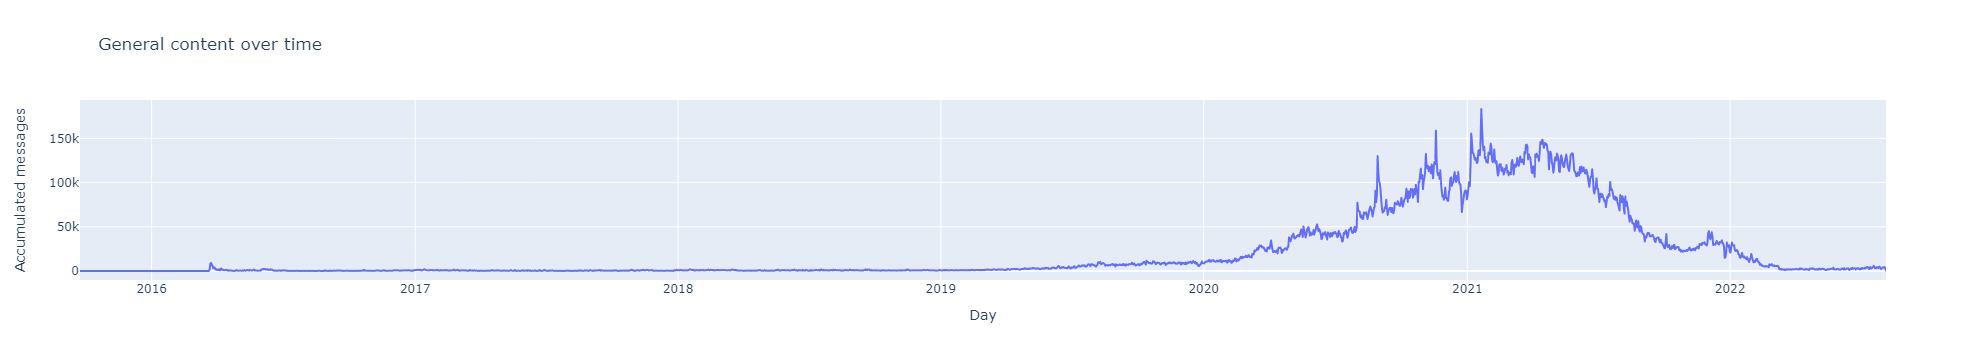

In [76]:
fig = px.line(posting_frequency, x=posting_frequency.index, y='posting_date', title="General content over time", labels={
                     "posting_date": "Accumulated messages",
                     "day": "Day"})
 
# displaying the title
#plt.title("Heatmap for content over days and hours")
fig.show()
#plt.savefig("images/overall_distribution.svg")
fig.write_image("images/overall_distribution.svg")

In [220]:
fwd_frequency = posting_day[['message']]

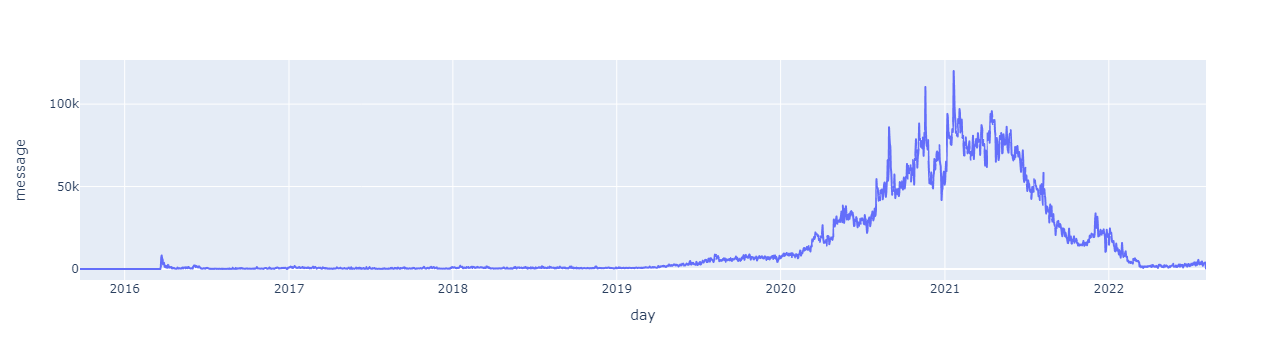

In [221]:
fig = px.line(fwd_frequency, x=fwd_frequency.index, y='message')
fig.show()

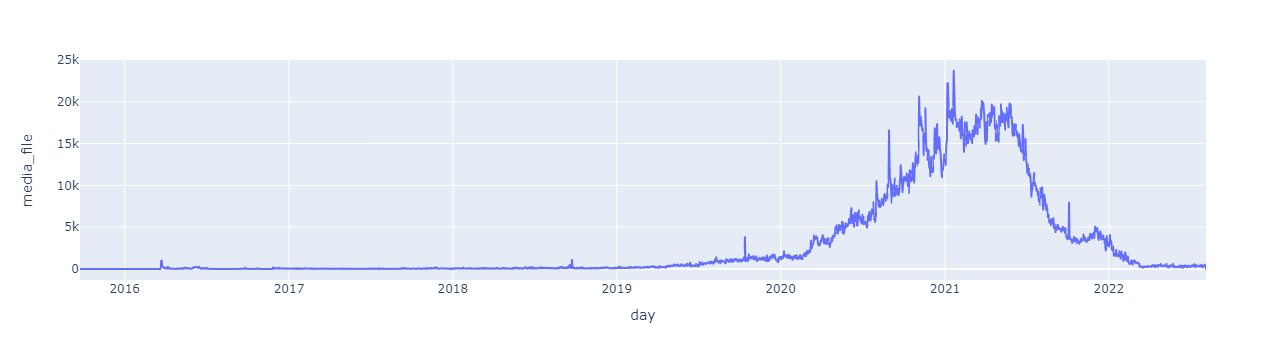

In [222]:
media_frequency = posting_day[['media_file']]
fig = px.line(media_frequency, x=media_frequency.index, y='media_file')
fig.show()

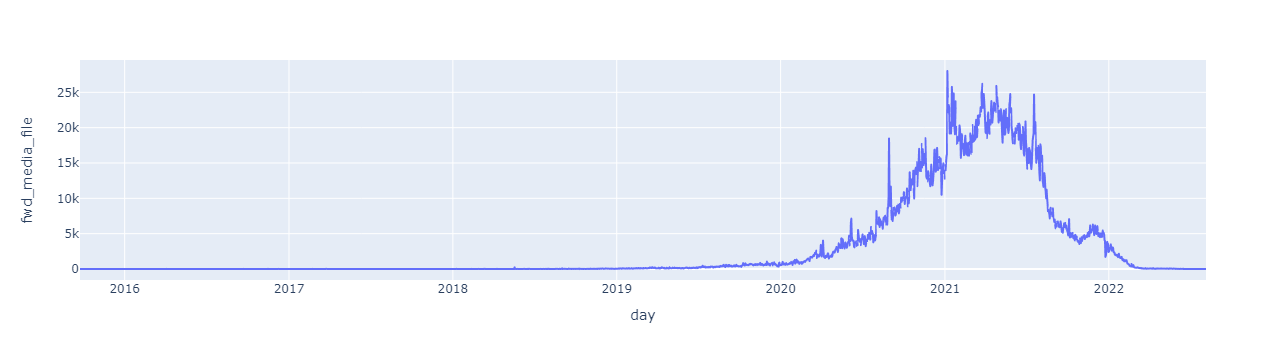

In [223]:
fwd_media_frequency = posting_day[['fwd_media_file']]
fig = px.line(fwd_media_frequency, x=fwd_media_frequency.index, y='fwd_media_file')
fig.show()

In [464]:
posting_day['link/message'] = posting_day['link_url']/posting_day['message']

In [473]:
posting_day['fwd_file/message'] = posting_day['fwd_media_file']/posting_day['fwd_message']

In [474]:
link_frequency = posting_day[['fwd_file/message']]
fig = px.line(link_frequency, x=link_frequency.index, y='fwd_file/message')
fig.show()

In [ ]:
link_frequency = posting_day[['link/message']]
fig = px.line(link_frequency, x=link_frequency.index, y='link/message')
fig.show()

In [282]:
author_frequency = test.groupby("day").author.nunique()
#author_frequency = author_frequency[["posting_date"]]

fig = px.line(x=author_frequency.index, y=author_frequency)
fig.show()

In [210]:
photo = test.query('(fwd_media_file_type == "photo") or (media_file_type == "photo")')

In [211]:
video = test.query('(fwd_media_file_type == "video") or (media_file_type == "video")')

In [212]:
voice_m = test.query('(fwd_media_file_type == "voice message") or (media_file_type == "voice message")')

In [214]:
photo_frequency = photo.groupby("day").count()
photo_frequency = photo_frequency[["posting_date"]]

fig = px.line(photo_frequency, x=photo_frequency.index, y='posting_date')
fig.write_image("images/photo_dist.svg")

In [215]:
video_frequency = video.groupby("day").count()
video_frequency = video_frequency[["posting_date"]]

fig = px.line(video_frequency, x=video_frequency.index, y='posting_date')
fig.write_image("images/video_dist.svg")

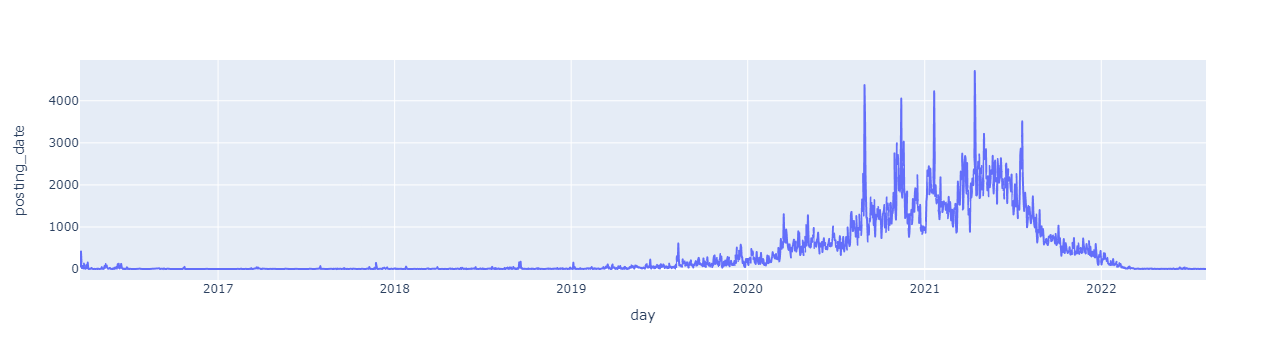

In [235]:
voice_frequency = voice_m.groupby("day").count()
voice_frequency = voice_frequency[["posting_date"]]

fig = px.line(voice_frequency, x=voice_frequency.index, y='posting_date')
fig.write_image("images/voice_message_dist.svg")
fig.show()

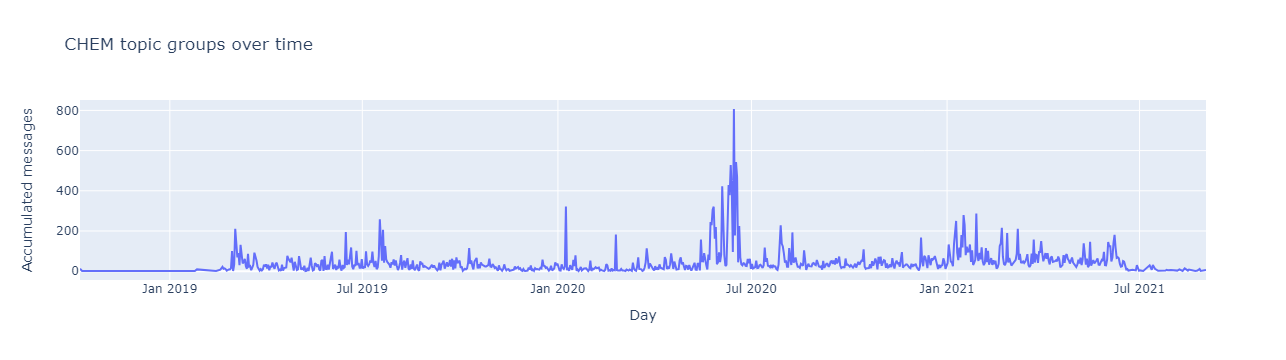

In [234]:
chem_frequency = CHEM_groups.groupby("day").count()
chem_frequency = chem_frequency[["posting_date"]]

fig = px.line(chem_frequency, x=chem_frequency.index, y='posting_date', title="CHEM topic groups over time", labels={
                     "posting_date": "Accumulated messages",
                     "day": "Day"})

fig.write_image("images/chem_group_content.svg")
fig.show()

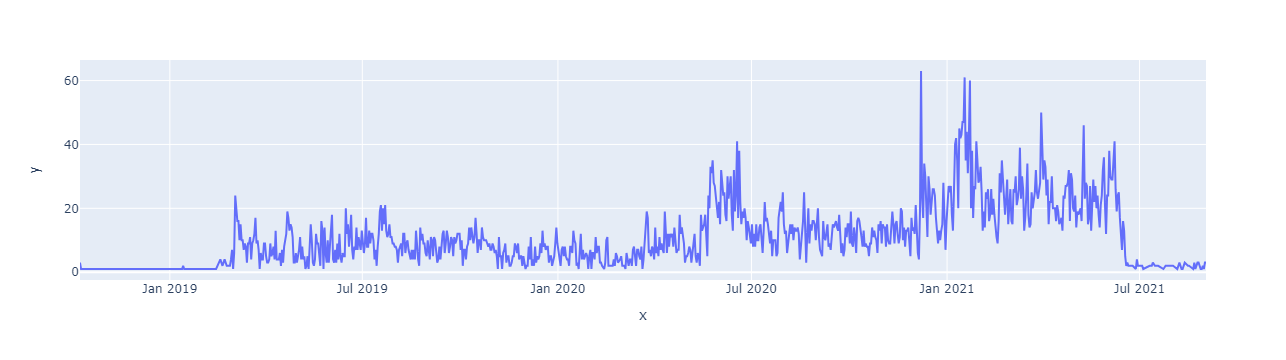

In [226]:
c_author_frequency = CHEM_groups.groupby("day").author.nunique()
#c_author_frequency = c_author_frequency[["posting_date"]]

fig = px.line(x=c_author_frequency.index, y=c_author_frequency)
fig.show()

In [232]:
reich_frequency = REICH_groups.groupby("day").count()
reich_frequency = reich_frequency[["posting_date"]]

fig = px.line(reich_frequency, x=reich_frequency.index, y='posting_date', title="Reichsbürger topic groups over time", labels={
                     "posting_date": "Accumulated messages",
                     "day": "Day"})
fig.write_image("images/reich_group_content.svg")

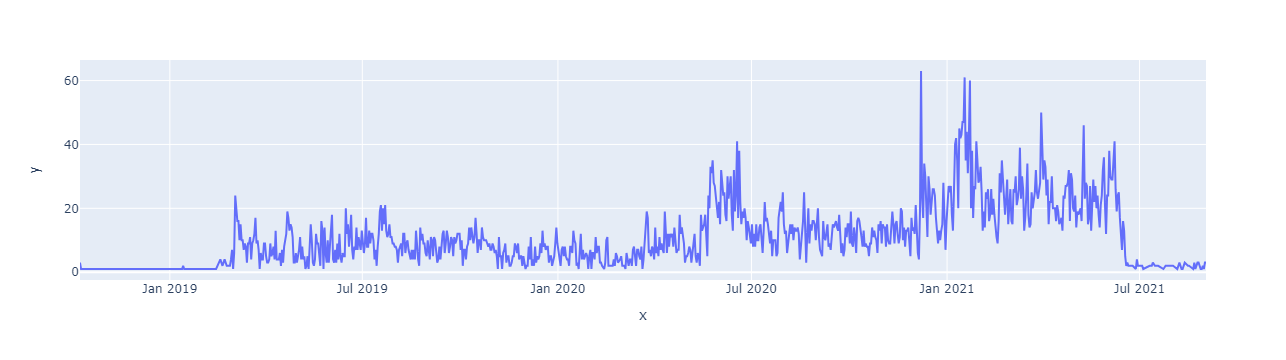

In [228]:
r_author_frequency = REICH_groups.groupby("day").author.nunique()
#r_author_frequency = r_author_frequency[["posting_date"]]

fig = px.line(x=c_author_frequency.index, y=c_author_frequency, title="Reichsbürger topic groups over time", labels={
                     "posting_date": "Accumulated messages",
                     "day": "Day"}))

fig.write_image("images/reich_group_content.svg")
fig.show()

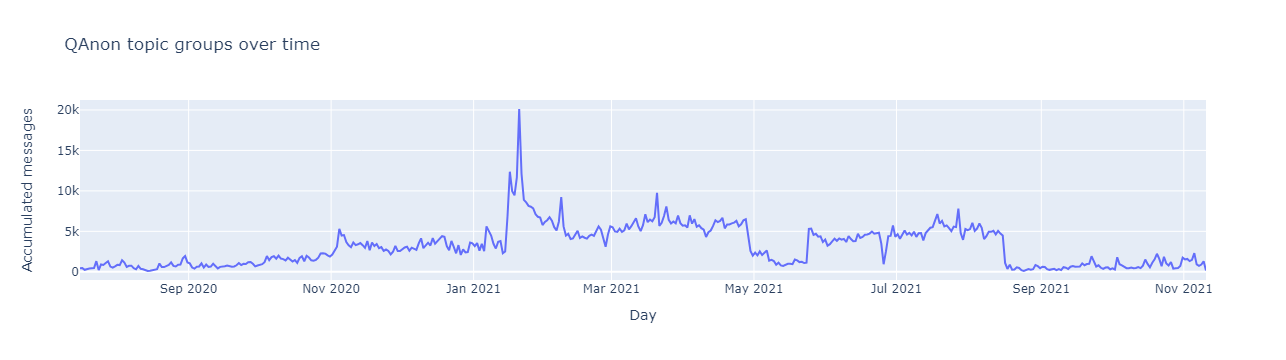

In [237]:
q_frequency = Q_groups.groupby("day").count()
q_frequency = q_frequency[["posting_date"]]

fig = px.line(q_frequency, x=q_frequency.index, y='posting_date', title="QAnon topic groups over time", labels={
                     "posting_date": "Accumulated messages",
                     "day": "Day"})
fig.write_image("images/q_group_content.svg")
fig.show()

In [287]:
q_author_frequency = Q_groups.groupby("day").author.nunique()
#q_author_frequency = q_author_frequency[["posting_date"]]

fig = px.line(x=q_author_frequency.index, y=q_author_frequency)
fig.show()

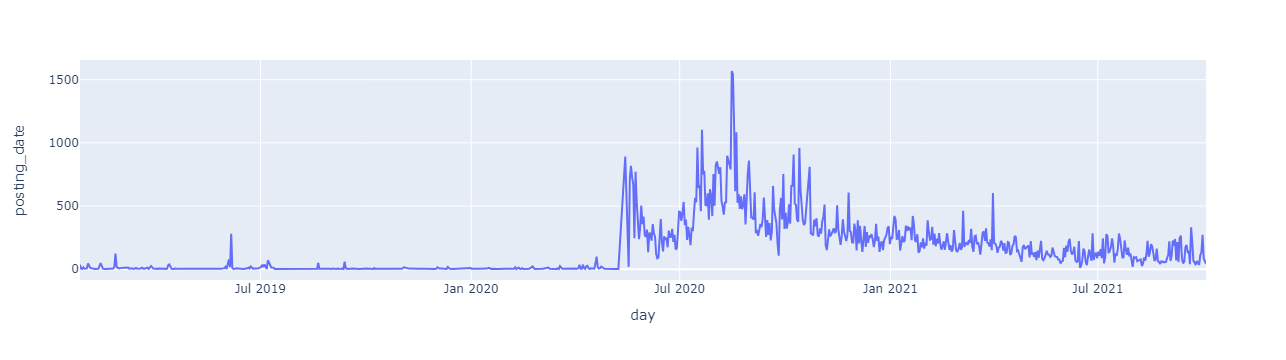

In [217]:
pizza_frequency = PIZZA_groups.groupby("day").count()
pizza_frequency = pizza_frequency[["posting_date"]]

fig = px.line(pizza_frequency, x=pizza_frequency.index, y='posting_date')
fig.write_image("images/pizza_group_content.svg")

In [289]:
p_author_frequency = PIZZA_groups.groupby("day").author.nunique()
#p_author_frequency = p_author_frequency[["posting_date"]]

fig = px.line(x=p_author_frequency.index, y=p_author_frequency)
fig.show()


In [189]:
mix_frequency = MIX_groups.groupby("day").count()
mix_frequency = mix_frequency[["posting_date"]]

fig = px.line(mix_frequency, x=mix_frequency.index, y='posting_date')
fig.write_image("images/mix_group_content.svg")

In [188]:
m_author_frequency = MIX_groups.groupby("day").author.nunique()
#m_author_frequency = m_author_frequency[["posting_date"]]

fig = px.line(x=m_author_frequency.index, y=m_author_frequency)

fig.write_image("images/mix_group_author.svg")

In [181]:
users_author = test.groupby("author").group_name.nunique()

In [182]:
len(users_author)

534342

In [220]:
from empiricaldist import Cdf
import statistics

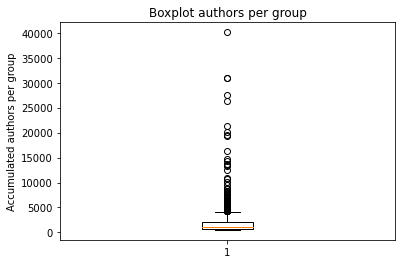

In [167]:
plt.boxplot(many)

plt.ylabel('Accumulated authors per group') 
  
# displaying the title
plt.title("Boxplot authors per group")
plt.show

plt.savefig("images/boxplot_author_group_top10per.svg")

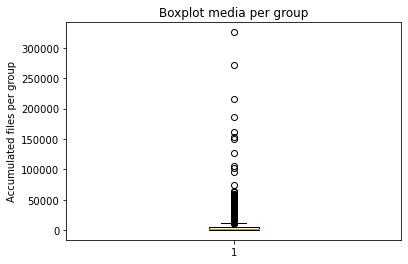

In [168]:
plt.boxplot(lot)

plt.ylabel('Accumulated files per group') 
  
# displaying the title
plt.title("Boxplot media per group")
plt.show

plt.savefig("images/boxplot_media_group_top10per.svg")

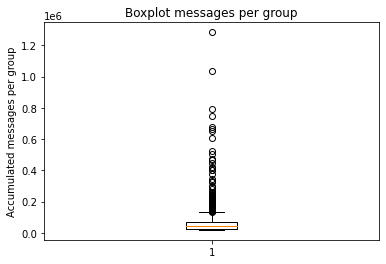

In [169]:
plt.boxplot(rich)

plt.ylabel('Accumulated messages per group') 
  
# displaying the title
plt.title("Boxplot messages per group")
plt.show

plt.savefig("images/boxplot_message_group_top10per.svg")

In [522]:
def decorate_cdf(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Quantity')
    plt.ylabel('CDF')
    plt.title(title)

In [150]:
la = group_info.n_authors.iloc[:-1]

In [151]:
len(la)

6477

In [257]:
many = [i for i in la if (i > np.percentile(la, 99)) and (i > 1)]
sum(many)/sum(la)

0.3702777136013113

In [258]:
less = [i for i in la if i < np.percentile(la, 99)]
sum(less)/sum(la)

0.6297222863986888

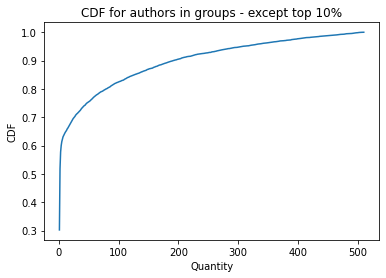

In [525]:
cdf = Cdf.from_seq(less)
cdf.plot()
cdf.quantile([0.25, 0.50, 0.75, 0.90, 0.999])
decorate_cdf("CDF for authors in groups - except top 10%")
plt.savefig("images/cdf_author_per_group_90.svg")

In [153]:
me = group_info.total_media.iloc[:-1]

In [253]:
lot = [i for i in me if i > np.percentile(la, 99)]
sum(lot)/sum(me)

0.7783565610282964

In [254]:
few = [i for i in me if i < np.percentile(la, 99)]
sum(few)/sum(me)

0.2216434389717036

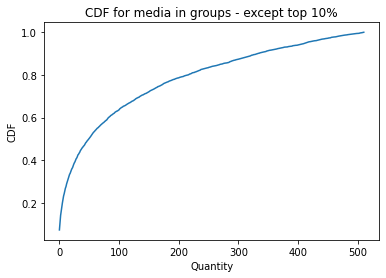

In [527]:
cdf = Cdf.from_seq(few)
cdf.plot()
cdf.quantile([0.25, 0.50, 0.75, 0.90, 0.999])
decorate_cdf("CDF for media in groups - except top 10%")
plt.savefig("images/cdf_media_per_group_90.svg")

2

In [156]:
#cdf
cm = group_info.n_messages_total.iloc[:-1]

In [255]:
rich = [i for i in cm if i > np.percentile(cm, 99)] 
sum(rich)/sum(cm)

0.32941991780011626

In [256]:
poor = [i for i in cm if i < np.percentile(cm, 99)] 
sum(poor)/sum(cm)

0.6705800821998837

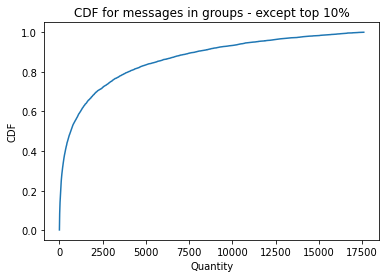

In [528]:
cdf = Cdf.from_seq(poor)
cdf.plot()
cdf.quantile([0.25, 0.50, 0.75, 0.90, 0.999])
decorate_cdf("CDF for messages in groups - except top 10%")
plt.savefig("images/cdf_messages_per_group_90.svg")

array([1.34000e+02, 9.27000e+02, 4.93500e+03, 1.76060e+04, 6.01267e+05])

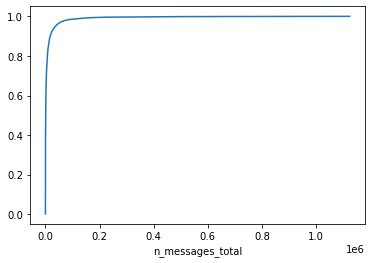

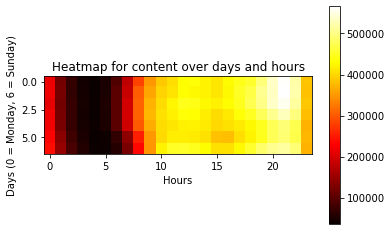

In [394]:
week_postings = test[["group_name", "posting_date", "weekday"]].copy()
week_postings["hour"] = week_postings["posting_date"].dt.hour

days_grouped = week_postings.groupby(["weekday", "hour"]).size()
days_grouped = days_grouped.unstack()

hm = plt.imshow(days_grouped, cmap='hot', interpolation='nearest')
plt.colorbar(hm)
plt.xlabel('Hours') 
plt.ylabel('Days (0 = Monday, 6 = Sunday)') 
  
# displaying the title
plt.title("Heatmap for content over days and hours")
plt.savefig("images/heatmap_weekly.svg")

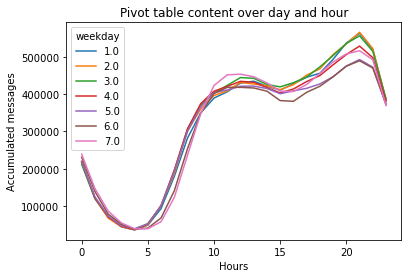

In [186]:
week_postings.pivot_table(index="hour", columns="weekday", aggfunc="size").plot(kind="line")
plt.xlabel('Hours') 
plt.ylabel('Accumulated messages') 
  
# displaying the title
plt.title("Pivot table content over day and hour")
plt.savefig("images/hourly_distribution.svg")

In [477]:
hours_passing = []
for i in range(7):
    hours_passing += days_grouped.iloc[i].tolist()
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hours_list = [4, 8, 12, 16, 20]
the_week = []
for day in weekdays:
    the_week.append(day)
    the_week += hours_list

weekly_posting_df = pd.DataFrame({"posting_numbers":hours_passing})

In [478]:
fig = px.line(weekly_posting_df, x=weekly_posting_df.index, y="posting_numbers")
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(0, 168, 4)),
        ticktext = the_week
    )
)
fig.show()

In [105]:
def link_removal(some_string):
    some_string = re.sub("<a.*?a>", "", some_string)
    some_string = re.sub("<code>.*?</code>", "", some_string)
    some_string = re.sub("<.*?>", "", some_string)

    return some_string

In [104]:
def create_text_bundle_tuples(df, denominator):
    
    #columns=["group_name", "author", "year", "denominator", "messages_text", "day_of_year", "week", "month", "n_messages", "n_replicated", "author_messages"]
    #text_df = pd.DataFrame(columns = columns) # Add if working with whisper transcriptions , "transcribed_message"])

    group_list = list(df["group_name"].dropna().unique())
    
    text_bundle_tuple_list = []
 
    #try:
    for g in group_list:
        group_bundle = df.loc[df["group_name"] == g]
        author_list = list(group_bundle["author"].dropna().unique())
        for a in tqdm(author_list):
            author_bundle = group_bundle.loc[group_bundle["author"] == a]
            year_list = list(author_bundle['year'].dropna().unique())
            n_author = len(author_bundle)
            for y in year_list:
                year_bundle = author_bundle.loc[author_bundle["year"] == y]
                denom_list = list(year_bundle[denominator].dropna().unique())
                for d in denom_list:
                    text_bundle = year_bundle.loc[year_bundle[denominator] == d]
                    if len(text_bundle) > 0:
                        text_bundle_tuple_list.append((text_bundle, denominator, g, a, y, d, n_author))


    return text_bundle_tuple_list

    #except: 
    #    return 'Type in valid denominator as string. Valid denominators are day_of_year, week, month'


In [354]:
text_bundle_tuples = create_text_bundle_tuples(topic_groups_enh, 'month')

100%|████████████████████████████████████████████████████████████████████████████████| 922/922 [00:05<00:00, 177.59it/s]


In [842]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import ldaseqmodel

import spacy
import pickle

import pyLDAvis
import pyLDAvis.gensim_models

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('german')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mangermaier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [840]:
def stop_words():
    return stopwords.words('german')

In [102]:
def exception_comp(a):
    t = []
    try: 
        t = re.split('[.!?]', a)
    except:
        pass
    
    return t

In [103]:
def sentence_detection(list_of_messages):
    
    cont = list_of_messages

    s = [[re.sub('[,\"\'.!?<>:=/]', '', sent).lower()] for mess in cont for sent in exception_comp(mess) if len(sent.split()) > 5]

    return s

In [1250]:
sol = sentence_detection(a)

In [100]:
def create_bundled_sentences(bundle_tuple):
    #bundle tuple consists of bundle_df and the used denominator
    df = bundle_tuple[0]
    denom = bundle_tuple[1]
    g = bundle_tuple[2]
    a = bundle_tuple[3]
    y = bundle_tuple[4]
    d = bundle_tuple[5]
    n_author = bundle_tuple[6]

    
    replied = df["replied_to"]
                                            
    df["message"] = df["message"].fillna("")
    df["transcribed_message"] = df["transcribed_message"].fillna("")
    df["message"] = df["message"].apply(link_removal)
    df["fwd_message"] = df["fwd_message"].fillna("")
    replication = df["uid"].isin(replied).sum()
    avg_score = df["Score"].sum()
    avg_count = df["Score"].notna().sum()
    newsguard_score = avg_count and avg_score / avg_count or 0 
    messages = sentence_detection(df["message"].to_list()) + sentence_detection(df["fwd_message"].to_list()) + sentence_detection(df["transcribed_message"].to_list())

    row = [g, a, y, d, messages, df["day_of_year"].iloc[0], df["week"].iloc[0], df["month"].iloc[0], len(df), replication, n_author, newsguard_score]
    
    return row

In [101]:
def create_text_bundles(bundle_tuple):
    #bundle tuple consists of bundle_df and the used denominator
    df = bundle_tuple[0]
    denom = bundle_tuple[1]
    g = bundle_tuple[2]
    a = bundle_tuple[3]
    y = bundle_tuple[4]
    d = bundle_tuple[5]
    n_author = bundle_tuple[6]
    
    replied = df["replied_to"]
                                            
    df["message"] = df["message"].fillna("")
    df["transcribed_message"] = df["transcribed_message"].fillna("")
    df["message"] = df["message"].apply(link_removal)
    df["fwd_message"] = df["fwd_message"].fillna("")
    replication = df["uid"].isin(replied).sum()
    avg_score = df["Score"].sum()
    avg_count = df["Score"].notna().sum()
    newsguard_score = avg_count and avg_score / avg_count or 0 
    messages = " ".join(df["message"].to_list())+" " + " ".join(df["fwd_message"].to_list()) + " ".join(df["transcribed_message"].to_list())
    messages_processed = re.sub('[,\"\'.!?<>:=/]', '  ', messages).lower()
    
    row = [g, a, y, d, messages_processed, df["day_of_year"].iloc[0], df["week"].iloc[0], df["month"].iloc[0], len(df), replication, n_author, newsguard_score]
    
    return row

In [99]:
def pool_text_bundles(number_of_cores, text_bundle_tuple_list, aim):

    data = []
    columns=["group_name", "author", "year", "denominator", "messages_processed", "day_of_year", "week", "month", "bundle_length", "replication", "number_of_authors", "newsguard_score"]
    
    # this opens a pool of cores that is then used to compute jobs for you
    pool = Pool(number_of_cores)

    # iterates over the list of channels and runs the function run()
    # on one core for each channel. Wrapping the call to pool.imap_unordered()
    # in tqdm() gives you a nice progress bar for the process.
    if aim == 'r':
        for result in tqdm(
            pool.imap_unordered(func=create_text_bundles, iterable=text_bundle_tuple_list),
            total=len(text_bundle_tuple_list)
            ):

                #pass
                data.append(result)
                # note: the "run" function already saves the results to
                # disk, so you don't need to do anything here. Alternatively,
                # you could return the individual channel's df from run() and
                # concatenate all the extracted data here
                # pass

        # it is important to close the pool of processes after completing all jobs
        pool.close()
        
        return pd.DataFrame(data, columns = columns)
        
    elif aim == 't':
        for result in tqdm(
            pool.imap_unordered(func=create_bundled_sentences, iterable=text_bundle_tuple_list),
            total=len(text_bundle_tuple_list)
            ):

                #pass
                data.append(result)
                # note: the "run" function already saves the results to
                # disk, so you don't need to do anything here. Alternatively,
                # you could return the individual channel's df from run() and
                # concatenate all the extracted data here
                # pass

        # it is important to close the pool of processes after completing all jobs
        pool.close()
        
        return pd.DataFrame(data, columns = columns)
        
        
    else: 
        return print('Please use \'r\' for \'reference\' or \'t\' for \'target\' as argument, to indicate the function of the dataset ')
        
    


In [ ]:
bundles.to_csv("/data/schwurbelarchiv/extracted_information/dataframes/text_bundles_monthwise.csv.gzip", compression = 'gzip')

In [56]:
#--------------------------------------------------------------------------------LDA--------------------------------------------------------------------------------------------------

In [831]:
#probably deprecated, because preprocessing is inherited in bundle logic
def preprocessing(df):
    # Remove punctuation
    df['messages_processed'] = df['messages_text'].map(lambda x: re.sub('[,\.!?]', ' ', x))
    
    # Convert the titles to lowercase
    df['messages_processed'] = df['messages_processed'].map(lambda x: x.lower())
    
    return df

In [832]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))        

In [833]:
def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [834]:
#method to delete the 5% most used words, as they are mostly meaningless fillwords, yet they are almost unique to every user as they often include common typos or colloquial language
def remove_words(words):
    # Get the set of unique words.
    uniques = []
    for word in words:
        if word not in uniques:
            uniques.append(word)

    # Make a list of (count, unique) tuples.
    counts = []
    for unique in uniques:
        count = 0              # Initialize the count to zero.
        for word in words:     # Iterate over the words.
            if word == unique:   # Is this word equal to the current unique?
                count += 1         # If so, increment the count
        counts.append((count, unique))


    counts.sort()            # Sorting the list puts the lowest counts first.
    counts.reverse() 

    remove = [word[1] for word in counts[:int(len(counts)*0.05)] if word[1][0].isalpha()]
    return remove

In [835]:
def LDA(text, stop_words):

    #for i in len(text_series)
    #    s = prepro.iloc[i][11]
    
    topics = []
    
    if len(text) > 100:

        p = list(sent_to_words(text.split()))
        p = remove_stopwords(p, stop_words)
        p = [word for word in p if word != []]

        r = remove_words(p)

        p = [word for word in p if word not in r]

        # Create Dictionary
        id2word = corpora.Dictionary(p)
        # Create Corpus
        texts = p
        # Term Document Frequency
        corpus = [id2word.doc2bow(text) for text in texts]

        # number of topics
        num_topics = 3
        # Build LDA model
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               workers = 10,
                                               num_topics=num_topics)



        res = lda_model.print_topics()
        for i in res:
            tmp = re.findall(r'\".*?\"', i[1])
            tmp = [''.join(char for char in item
                            if char not in string.punctuation)
                    for item in tmp if item != '']
            topics.append(tmp)

        doc_lda = lda_model[corpus]

        return topics
    
    else:
        return '!! text size too small to make meaningful LDA !!'

In [836]:
def apply_LDA(row):
    
    row['topics'] = LDA(row['messages_processed'], stop_words)
    
    return row

In [837]:
def pool_LDA(number_of_cores, df):

    data = []
    
    list_of_df_rows = [df.iloc[i] for i in range(len(df))]
    
    #columns=["group_name", "author", "year", "denominator", "messages_text", "day_of_year", "week", "month", "bundle_length", "replication", "number_of_authors"]
    
    # this opens a pool of cores that is then used to compute jobs for you
    pool = Pool(number_of_cores)

    # iterates over the list of channels and runs the function run()
    # on one core for each channel. Wrapping the call to pool.imap_unordered()
    # in tqdm() gives you a nice progress bar for the process.
    
    
    for result in tqdm(
        pool.imap_unordered(func=apply_LDA, iterable=list_of_df_rows),
        total=len(list_of_df_rows)
        ):
            
            #pass
            data.append(result)
            # note: the "run" function already saves the results to
            # disk, so you don't need to do anything here. Alternatively,
            # you could return the individual channel's df from run() and
            # concatenate all the extracted data here
            # pass

    # it is important to close the pool of processes after completing all jobs
    pool.close()
    
    df = pd.DataFrame(data)
    
    return df

In [ ]:
lda_res = pool_LDA(100, MIX_df[:100])

  4%|███▌                                                                                    | 4/100 [02:31<1:01:27, 38.42s/it]

In [ ]:
lda_res.topics

In [ ]:
#--------------------------------------------------------------------------------LDA--------------------------------------------------------------------------------------------------

In [106]:
text_bundle_CHEM = create_text_bundle_tuples(CHEM_groups, 'month')

100%|████████████████████████████████████████████████████████████████████████████████| 915/915 [00:01<00:00, 531.23it/s]


In [107]:
text_bundle_Q = create_text_bundle_tuples(Q_groups, 'month')

100%|████████████████████████████████████████████████████████████████████████████| 28445/28445 [01:38<00:00, 287.91it/s]


In [108]:
text_bundle_REICH = create_text_bundle_tuples(REICH_groups, 'month')

100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 616.60it/s]


In [109]:
#text_bundle_NWO = create_text_bundle_tuples(NWO_groups, 'month')

In [110]:
text_bundle_PIZZA = create_text_bundle_tuples(PIZZA_groups, 'month')

100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 581.04it/s]


In [111]:
text_bundle_MIX = create_text_bundle_tuples(MIX_groups, 'month')

100%|██████████████████████████████████████████████████████████████████████████████| 2692/2692 [00:04<00:00, 543.36it/s]


In [112]:
CHEM_df = pool_text_bundles(100, text_bundle_CHEM, 'r')

100%|██████████████████████████████████████████████████████████████████████████████| 3856/3856 [00:23<00:00, 161.45it/s]


In [113]:
Q_df = pool_text_bundles(100, text_bundle_Q, 'r')

100%|████████████████████████████████████████████████████████████████████████████| 94730/94730 [10:23<00:00, 151.94it/s]


In [114]:
REICH_df = pool_text_bundles(100, text_bundle_REICH, 'r')

100%|████████████████████████████████████████████████████████████████████████████| 14389/14389 [01:41<00:00, 141.26it/s]


In [115]:
PIZZA_df = pool_text_bundles(100, text_bundle_PIZZA, 'r')

100%|████████████████████████████████████████████████████████████████████████████| 10912/10912 [01:09<00:00, 157.18it/s]


In [116]:
#NWO_df = pool_text_bundles(100, text_bundle_NWO, 'r')

In [117]:
MIX_df = pool_text_bundles(100, text_bundle_MIX, 'r')

100%|████████████████████████████████████████████████████████████████████████████| 74539/74539 [08:36<00:00, 144.22it/s]


In [ ]:
#s_MIX_df = pool_text_bundles(100, text_bundle_MIX, 't')

In [1499]:
REFERENCE_df = pd.concat([Q_df, CHEM_df, REICH_df, PIZZA_df])

In [917]:
REFERENCE_df.to_csv('/data/schwurbelarchiv/extracted_information/dataframes/references_for_keyness.csv.gzip', compression = 'gzip')

In [ ]:
import spacy
import spacy_transformers

nlp = spacy.load("de_dep_news_trf")

In [ ]:
from corpus_toolkit import corpus_tools as ct

In [ ]:
for check in t:
    doc = nlp(check)
    result = ' '.join([x.lemma_ for x in doc])
    t_lemma.append(result)

In [119]:
aim = {'MIX_df' : MIX_df}

In [124]:
df_dict = {'CHEM_df' : CHEM_df, 'REICH_df' : REICH_df, 'PIZZA_df' : PIZZA_df, 'Q_df' : Q_df}

In [84]:
def sort_dictionary(dict_):
    return dict(sorted(dict_.items(), key = lambda x: x[1], reverse = True))

In [85]:
def word_list(df):
    start = datetime.datetime.now()
    concat = ''.join(df.messages_processed)
    word_list = list(sent_to_words(concat.split()))
    word_list = remove_stopwords(word_list, stop_words())
    word_list = [word[0] 
                 for word in word_list
                 if word != []]
    end = datetime.datetime.now()
    print('word_list prepared in ' + str(end-start))
    return word_list

In [86]:
def dict_cleansing(dict_, threshold):
    
    clean = {key: value 
             for key, value in dict_.items() 
             if value > threshold}
    
    return clean

In [87]:
def dict_value_perc(dict_, percentile):
    
    return np.percentile(list(dict_.values()), percentile)

In [88]:
def master_dict(key_dict, freq_dict):
    
    freq_threshold = dict_value_perc(freq_dict, 99)
    freq_median = dict_value_perc(freq_dict, 50)
    
    keyness_threshold = dict_value_perc(key_dict, 99)
    keyness_median = dict_value_perc(key_dict, 50)
    

    print(keyness_threshold)
    print(freq_threshold)
    #print(keyness_median)
    #print(freq_median)
    
    
    
    result_dict = {term: [keyness, freq_dict[term]] 
             for term, keyness in key_dict.items() 
             if 
             (
                 (keyness >= keyness_threshold)
                 and 
                 (freq_dict[term] >= freq_median)
             )
             or 
             (
                 (freq_dict[term] >= freq_threshold) 
                 and 
                 (keyness >= keyness_median)
             ) 
            }
    
    return result_dict

In [89]:
def add_normalized_keyness_to_dict(key_dict):

    list_ = []
    for con in key_dict.keys():
        #list of lists with key and term values
        help_ = [[key, value[0], value[1], 0] for key, value in key_dict[con].items()]
        #list with all keynesses
        vals = [i[1] for i in help_]
        #calculate normalized keynesses
        norm = (vals-np.min(vals))/(np.max(vals)-np.min(vals))

        #scramble together in a new dictionary
        tmp_dict = {help_[index][0]: [help_[index][1], help_[index][2], a] for index, a in enumerate(norm)}
        list_.append(tmp_dict)
        
    dict_ = dict(zip(list(key_dict.keys()), list_))

    #structure of returned conspirational terms: {consp_theory:{term:[keyness, frequency, NORMALIZED_keyness]}}
    return dict_

In [90]:
def keyness(df_dict):   
    print('check1')
    #full text corpus as reference
    reference = pd.concat(df_dict)
    print('check2')
    reference = word_list(reference)
    print('check3')
    ref_corp = ct.frequency(ct.tokenize(reference))
    
    print('check1')
    #dictionary containing all frequency dictionaries
    freq_corp_dict = {key: sort_dictionary(ct.frequency(ct.tokenize(word_list(df)))) 
                for key, df in df_dict.items()}
    print('check2')
    print(len(list(freq_corp_dict.values())[0].values()))
    #cleaning to get only words, that appear more than once
    freq_corp_dict = {key: dict_cleansing(freq_corp_dict[key], 2) 
                      for key in freq_corp_dict.keys()}
    print(len(list(freq_corp_dict.values())[0].values()))
    
    
    
    #dictionary containing all keyness dictionaries
    keyness_corp_dict = {key: sort_dictionary(ct.keyness(corp, ref_corp, effect = "odds-ratio"))
                   for key, corp in freq_corp_dict.items()}
    print('check3')
    print(len(list(keyness_corp_dict.values())[0].values()))
    #cleaning to get rid of null values
    keyness_corp_dict = {key: dict_cleansing(keyness_corp_dict[key], 1)
                         for key in keyness_corp_dict.keys()}
    print(len(list(keyness_corp_dict.values())[0].values()))
    

    dict_ = {key: master_dict(keyness, freq_corp_dict[key]) 
             for key, keyness in keyness_corp_dict.items()}
    

    
    normed = add_normalized_keyness_to_dict(dict_)
    
    return normed

In [2858]:
start = datetime.datetime.now()
alt1_final_key_dict = keyness(df_dict)
end = datetime.datetime.now()
dur = end-start
print(dur)

check1
check2
word_list prepared in 0:06:54.163563
check3
check1
word_list prepared in 0:00:07.509510
word_list prepared in 0:00:57.415899
word_list prepared in 0:00:21.915306
word_list prepared in 0:04:43.779359
check2
41921
13000
check3
396216
9757
48.94983049526555
11.0
5.09574219949513
85.0
12.954421283954844
37.0
1.4956239640325681
304.0
0:14:06.640458


In [ ]:
#################### create the samples for annotation ##############

In [1697]:
CHEM_sample = CHEM_df.query(
    'bundle_length > 15').sample(
    n = 100 ,random_state = 122)
impr_CHEM_sample = pd.DataFrame([CHEM_sample.iloc[i] for i in range(len(CHEM_sample)) if len(CHEM_sample.iloc[i, CHEM_sample.columns.get_loc('messages_processed')].split()) > 100])

impr_CHEM_sample = impr_CHEM_sample.sample(
    n = 19 ,random_state = 123)
impr_CHEM_sample['is_CHEM_mathias'], impr_CHEM_sample['is_CHEM_algo'] = 0, 0

In [2081]:
Q_sample = Q_df.query(
    'bundle_length > 15').sample(
    n = 100 ,random_state = 123)
impr_Q_sample = pd.DataFrame([Q_sample.iloc[i] for i in range(len(Q_sample)) if len(Q_sample.iloc[i, Q_sample.columns.get_loc('messages_processed')].split()) > 100])

Q_sample = impr_Q_sample.sample(
    n = 50 ,random_state = 123)
Q_sample['is_Q_mathias'], Q_sample['is_Q_algo'] = 0, 0

In [1640]:
REICH_sample = REICH_df.query(
    'bundle_length > 15').sample(
    n = 100 ,random_state = 123)
impr_REICH_sample = pd.DataFrame([REICH_sample.iloc[i] for i in range(len(REICH_sample)) if len(REICH_sample.iloc[i, REICH_sample.columns.get_loc('messages_processed')].split()) > 100])

REICH_sample = impr_REICH_sample.sample(
    n = 50 ,random_state = 123)

REICH_sample['is_REICH_mathias'], REICH_sample['is_REICH_algo'] = 0, 0

In [1641]:
PIZZA_sample = PIZZA_df.query(
    'bundle_length > 15').sample(
    n = 100 ,random_state = 123)
impr_PIZZA_sample = pd.DataFrame([PIZZA_sample.iloc[i] for i in range(len(PIZZA_sample)) if len(PIZZA_sample.iloc[i, PIZZA_sample.columns.get_loc('messages_processed')].split()) > 100])

PIZZA_sample = impr_PIZZA_sample.sample(
    n = 50 ,random_state = 123)
PIZZA_sample['is_PIZZA_mathias'], PIZZA_sample['is_PIZZA_algo'] = 0, 0

In [1783]:
#CHEM_sample.to_csv('CHEMTRAIL_sample_annotated.csv')

In [2213]:
#Q_sample.to_csv('QANON_sample_annotated.csv')

In [2305]:
#REICH_sample.to_csv('REICHSBUERGER_sample_annotated.csv')

In [2390]:
#PIZZA_sample.to_csv('PIZZAGATE_sample_annotated.csv')

In [190]:
CHEM_sample = pd.read_csv('CHEMTRAIL_sample_annotated.csv')

In [191]:
Q_sample = pd.read_csv('QANON_sample_annotated.csv')

In [192]:
REICH_sample = pd.read_csv('REICHSBUERGER_sample_annotated.csv')

In [193]:
PIZZA_sample = pd.read_csv('PIZZAGATE_sample_annotated.csv')

In [194]:
sample_dict = {'CHEM': CHEM_sample, 'Q' : Q_sample, 'REICH' : REICH_sample, 'PIZZA' : PIZZA_sample}

In [195]:
def alg_detection(data, threshold, theory):
    
    for i in range(len(data)-1):
        row = data.iloc[i]
        theories = []
        if row['count_conspirational_terms'] == row['count_conspirational_terms']:
            if row['count_conspirational_terms'][f'{theory}_df'] > threshold*row['bundle_word_count']:
                row[f'is_{theory}_algo'] = 1
            else:
                row[f'is_{theory}_algo'] = 0
       
               
        data.iloc[i] = row
    
    return data

In [196]:
def ROC_prep(data, threshold, theory):
    
    data = alg_detection(data, threshold, theory)[[f'is_{theory}_mathias', f'is_{theory}_algo']]
    
    data['true_positive'] = 0
    data['false_positive'] = 0
    data['true_negative'] = 0
    data['false_negative'] = 0
    
    for i in range(len(data[f'is_{theory}_mathias'])-1):
    
        row = data.iloc[i] 
        if (row[f'is_{theory}_mathias'] == 0) & (row[f'is_{theory}_algo'] == 1):
            row['false_positive'] = 1
        elif (row[f'is_{theory}_mathias'] == 1) & (row[f'is_{theory}_algo'] == 1):
            row['true_positive'] = 1
        elif (row[f'is_{theory}_mathias'] == 0) & (row[f'is_{theory}_algo'] == 0):
            row['true_negative'] = 1
        elif (row[f'is_{theory}_mathias'] == 1) & (row[f'is_{theory}_algo'] == 0):
            row['false_negative'] = 1

        data.iloc[i] = row
        
    tpr = sum(data['true_positive'])/(sum(data['true_positive'])+sum(data['false_negative']))
    fpr = sum(data['false_positive'])/(sum(data['false_positive'])+sum(data['true_negative']))
    
    return (tpr, fpr, threshold)

In [205]:
ROC = [ROC_prep(sample_dict['REICH'], i, 'REICH') for i in np.linspace(0, 0.1, 101)]

tpr = [i[0] for i in ROC]
fpr = [i[1] for i in ROC]

In [125]:
threshold_dict = {}
for key, value in sample_val.items():
    ROC = [ROC_prep(value, i, key) for i in np.linspace(0, 0.1, 101)]
    threshold_tuple = optimal_threshold(ROC)
    tmp = {key:threshold_tuple}
    threshold_dict.update(tmp)

In [2830]:
threshold_dict

{'CHEM': (0.19416666666666668, 0.031),
 'Q': (0.10785953177257523, 0.007),
 'REICH': (0.24035087719298245, 0.027),
 'PIZZA': (0.23214285714285715, 0.012)}

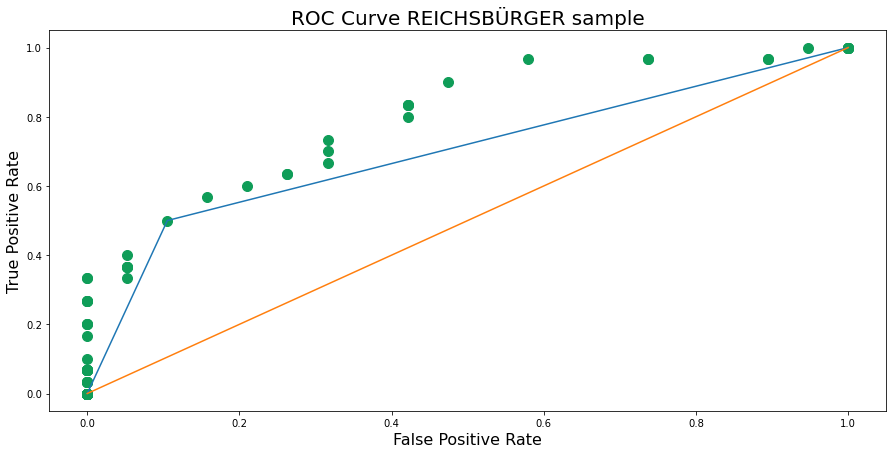

In [206]:
import seaborn as sns
#sns.set()
plt.figure(figsize=(15,7))
#sns.scatterplot(x = fpr,y = tpr,color='#0F9D58',s=100)
plt.scatter(fpr, tpr,color='#0F9D58',s=100)
plt.title('ROC Curve REICHSBÜRGER sample',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.plot([0,ROC[27][1], 1], [0, ROC[27][0], 1])
plt.plot([0,1])
plt.savefig("images/ROC_Reich.svg")

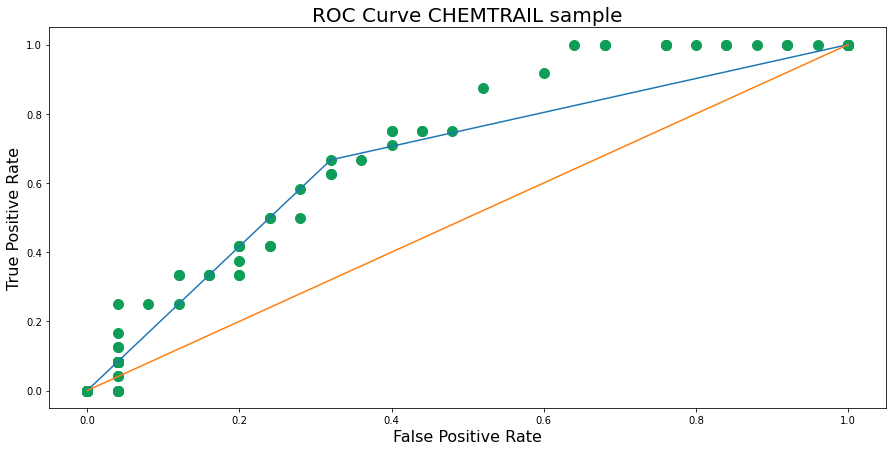

In [207]:
ROC = [ROC_prep(sample_dict['CHEM'], i, 'CHEM') for i in np.linspace(0, 0.1, 101)]

tpr = [i[0] for i in ROC]
fpr = [i[1] for i in ROC]

plt.figure(figsize=(15,7))
#sns.scatterplot(x = fpr,y = tpr,color='#0F9D58',s=100)
plt.scatter(fpr, tpr,color='#0F9D58',s=100)
plt.title('ROC Curve CHEMTRAIL sample',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.plot([0,ROC[31][1], 1], [0, ROC[31][0], 1])
plt.plot([0,1])
plt.savefig("images/ROC_Chem.svg")

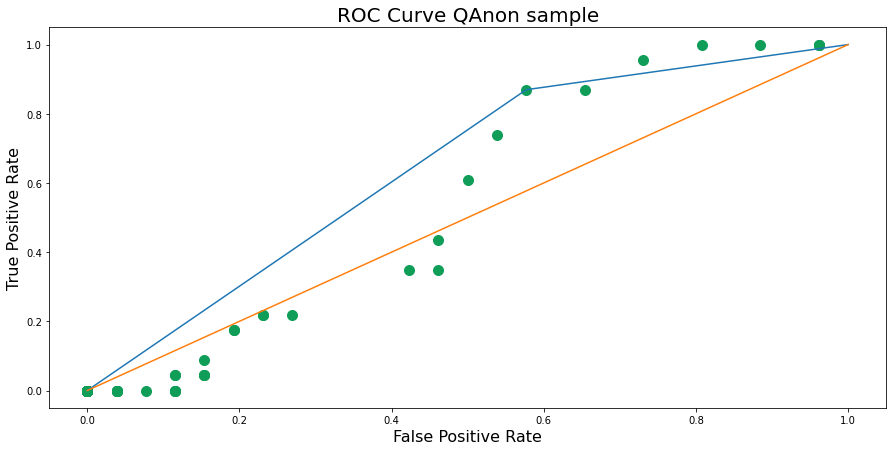

In [208]:
ROC = [ROC_prep(sample_dict['Q'], i, 'Q') for i in np.linspace(0, 0.1, 101)]

tpr = [i[0] for i in ROC]
fpr = [i[1] for i in ROC]

plt.figure(figsize=(15,7))
#sns.scatterplot(x = fpr,y = tpr,color='#0F9D58',s=100)
plt.scatter(fpr, tpr,color='#0F9D58',s=100)
plt.title('ROC Curve QAnon sample',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.plot([0,ROC[7][1], 1], [0, ROC[7][0], 1])
plt.plot([0,1])
plt.savefig("images/ROC_QAnon.svg")

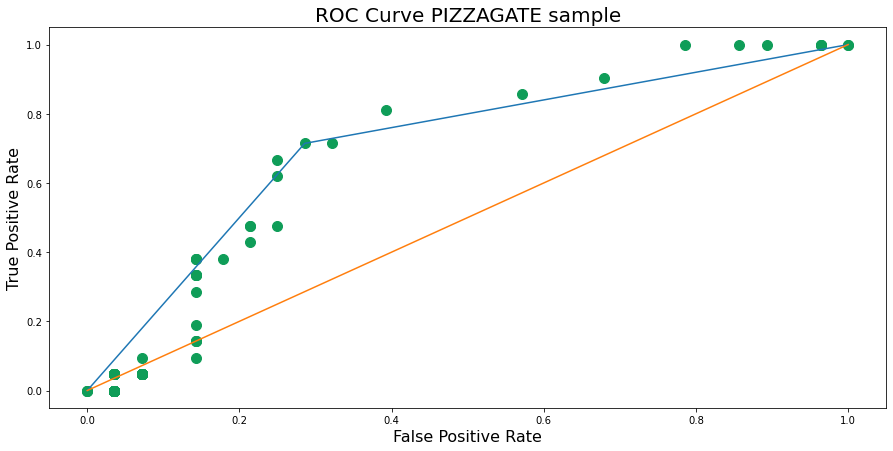

In [209]:
ROC = [ROC_prep(sample_dict['PIZZA'], i, 'PIZZA') for i in np.linspace(0, 0.1, 101)]

tpr = [i[0] for i in ROC]
fpr = [i[1] for i in ROC]

plt.figure(figsize=(15,7))
#sns.scatterplot(x = fpr,y = tpr,color='#0F9D58',s=100)
plt.scatter(fpr, tpr,color='#0F9D58',s=100)
plt.title('ROC Curve PIZZAGATE sample',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.plot([0,ROC[12][1], 1], [0, ROC[12][0], 1])
plt.plot([0,1])
plt.savefig("images/ROC_PIZZA.svg")

In [201]:
def Area(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

In [202]:
def optimal_threshold(ROC_list):
    #ROC_list indexing: ROC_list[][0] = tpr, ROC_list[][1] = fpr, ROC_list[][2] = threshold
    
    data = ROC_list
    area_list = []
    
    for i in range(len(data)):
        area = 0.0
        if data[i][0] > data[i][1]:
            corners = [(0,0), (data[i][1], data[i][0]), (1,1)]
            area = Area(corners)
        area_list.append((area, data[i][2]))
    
    optimum = max(area_list, key=lambda item: item[0])
    
    return optimum

In [189]:
aim_test = {'MIX_df' : MIX_df[:20]}

In [309]:
def add_conspirational_information_to_bundle(dict_): #PROD: (df_dict, ref_df_dict)
    #PROD: final_key_dict = keyness(ref_df_dict)
    
    df_dict = dict_
    
    for con_df in list(df_dict.keys()):
        for bundle in tqdm(df_dict[con_df]['messages_processed']):
            theory_dict = {}
            theory_len_dict = {}
            split = bundle.split()
            #PROD: 
            for k in trans_final_key_dict.keys():
                ind_terms = {}
                #topic_key_len = len(final_key_dict[k])
                for i in trans_final_key_dict[k].keys():
                    count = split.count(i)
                    if count > 0:
                        tmp = {i:count*trans_final_key_dict[k][i]}
                        ind_terms.update(tmp)

                #hit_count = len(ind_terms)
                tmp = {k:ind_terms}
                tmp_len = {k:len(ind_terms)} 
                theory_dict.update(tmp)
                theory_len_dict.update(tmp_len)
                #print(k[:-3])
                
            #print(theory_len_dict)
            df_dict[con_df].loc[df_dict[con_df]['messages_processed'] == bundle, ['conspirational_terms']] = [theory_dict]
            df_dict[con_df].loc[df_dict[con_df]['messages_processed'] == bundle, ['count_conspirational_terms']] = [theory_len_dict]
            df_dict[con_df].loc[df_dict[con_df]['messages_processed'] == bundle, ['bundle_word_count']] = len(split)
            df_dict[con_df].loc[df_dict[con_df]['messages_processed'] == bundle, ['conspiracy_keys']] = 'nan'
            df_dict[con_df].loc[df_dict[con_df]['messages_processed'] == bundle, ['conspiracy_theory']] = 'nan'
            df_dict[con_df].loc[df_dict[con_df]['messages_processed'] == bundle, ['action_quotient']] = action_quotient(bundle)
            
            
            
    for con_df in list(df_dict.keys()): 
        for theory in trans_final_key_dict.keys():
            t = theory[:-3]
            df_dict[con_df][f'is_{t}_algo'] = 0

            
    return df_dict

In [191]:
testing = add_conspirational_information_to_bundle(aim_test)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.38s/it]


In [204]:
sample_val = add_conspirational_information_to_bundle(sample_dict)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.23it/s]


In [203]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

def add_conspirational_information_to_bundle(dict_): #PROD: (df_dict, ref_df_dict)
    #PROD: final_key_dict = keyness(ref_df_dict)
    
    df_dict = dict_
    
    for con_df in list(df_dict.keys()):
        for bundle in tqdm(df_dict[con_df]['messages_processed']):
            theory_dict = {}
            theory_len_dict = {}
            split = bundle.split()
            #PROD: 
            for k in trans_final_key_dict.keys():
                ind_terms = {}
                #topic_key_len = len(final_key_dict[k])
                for i in trans_final_key_dict[k].keys():
                    count = split.count(i)
                    if count > 0:
                        tmp = {i:count*trans_final_key_dict[k][i]}
                        ind_terms.update(tmp)

                #hit_count = len(ind_terms)
                tmp = {k:ind_terms}
                tmp_len = {k:len(ind_terms)} 
                theory_dict.update(tmp)
                theory_len_dict.update(tmp_len)
                #print(k[:-3])
                
            #print(theory_len_dict)
            df_dict[con_df].loc[df_dict[con_df]['messages_processed'] == bundle, ['conspirational_terms', 'count_conspirational_terms', 'bundle_word_count', 'conspiracy_keys', 'conspiracy_theory']] = [[theory_dict], [theory_len_dict], len(split), np.nan, np.nan]

            
            
            
    for con_df in list(df_dict.keys()): 
        for theory in trans_final_key_dict.keys():
            t = theory[:-3]
            df_dict[con_df][f'is_{t}_algo'] = 0

            
    return df_dict

In [ ]:
sample_val

In [296]:
testing = add_conspirational_information_to_bundle(aim)

100%|█████████████████████████████████████████████████████████████████████████████| 74545/74545 [31:55<00:00, 38.92it/s]


In [300]:
full_analysis = {}
for key, value in testing.items():
    for t, v in threshold_dict.items():
        full_analysis[key] = alg_detection(value, v[1], t)

100%|████████████████████████████████████████████████████████████████████████████| 74544/74544 [01:25<00:00, 873.58it/s]


In [ ]:
#only conspiratorial messages
conspiracy = full_analysis['MIX_df'].query('is_CHEM_algo != 0 or is_REICH_algo != 0 or is_PIZZA_algo != 0 or is_Q_algo != 0')

In [131]:
for t, v in threshold_dict.items():
    print(v)

(0.1775, 0.023)
(0.14632107023411373, 0.007)
(0.21315789473684213, 0.015)
(0.2142857142857143, 0.012)


In [ ]:
full_analysis = {}
for key, value in testing.items():
    for t, v in threshold_dict.items():
        full_analysis[key] = alg_detection(value, v[1], t)

In [303]:
full_analysis['MIX_df'].to_csv('full_analysis.csv')

In [171]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

import nltk
corp = nltk.corpus.ConllCorpusReader('.', 'tiger_release_aug07.corrected.16012013.conll09',
                                     ['ignore', 'words', 'ignore', 'ignore', 'pos'],
                                     encoding='utf-8')

import random

tagged_sents = list(corp.tagged_sents())
random.shuffle(tagged_sents)

# set a split size: use 90% for training, 10% for testing
split_perc = 0.1
split_size = int(len(tagged_sents) * split_perc)
train_sents, test_sents = tagged_sents[split_size:], tagged_sents[:split_size]

from ClassifierBasedGermanTagger.ClassifierBasedGermanTagger import ClassifierBasedGermanTagger

tagger = ClassifierBasedGermanTagger(train=train_sents)
accuracy = tagger.evaluate(test_sents)
accuracy





In [ ]:
#------------------------------------------RPC-LEX----------------------------------

In [244]:
rpc_lex = pd.read_csv('rpc_lex.csv', delimiter = ';')

In [245]:
rpc_cons = list(rpc_lex.query('category_en == "Conspiracy"')['term'])

In [1327]:
c = final_key_dict['CHEM_df']
d = rpc_cons

In [ ]:
for i in final_key_dict['CHEM_df']:


In [1296]:
old_ref = aim['MIX_df']

In [92]:
def calculate_average_key_values(df_dict):

    for df in df_dict.values():
        for index, dict_ in tqdm(enumerate(df.conspirational_terms)):
            topic_overall_keyness = {}
            try:
                for topic, term_dic in df.conspirational_terms[index].items():

                    countable = []
                    for term, numeric in term_dic.items():
                        for key_index, keyness in enumerate(numeric):
                            if key_index%3 == 2:
                                countable.append(keyness)
                    if len(countable) > 0:
                        tmp = {topic[:-3] : sum(countable)/len(countable)}
                        topic_overall_keyness.update(tmp)

                    df.iloc[index, df.columns.get_loc('conspiracy_keys')] = [topic_overall_keyness]
            except:
                continue
            
    return df_dict
        

In [985]:
average_keys = calculate_average_key_values(testing)

54275it [00:35, 1542.06it/s]


In [1375]:
len(rpc_cons)

1176

In [246]:
key_terms = [w for i in final_key_dict.keys() for w in final_key_dict[i]]

In [247]:
common = [i for i in rpc_cons if i in key_terms]

In [252]:
rpc_lex.loc[rpc_lex['term'].isin(key_terms)].groupby('category_en').count()[['term']].sum()

term    670
dtype: int64

In [ ]:
#--------------------------------------------rpc-lex---------------------

In [238]:
for key, value in trans_final_key_dict.items():
    
    print(key, len(value))

CHEM_df 1188
REICH_df 1006
PIZZA_df 877
Q_df 1053


In [239]:
o_prep = {}

for i in final_key_dict.keys():
    l = []
    for term in final_key_dict[i].keys():
        l.append(term)
    tmp = {i:l}
    o_prep.update(tmp)


In [ ]:
o = {}
for i in o_prep.keys():
    o_sub = {}
    for n in o_prep.keys():
        if i != n:
            o_lst = list(set(o_prep[i]) & set(o_prep[n]))
            tmp = {f'{i}_{n}': o_lst}
            
        o_sub.update(tmp)
    print(o_sub)
    o.update(o_sub)
print(o)

In [243]:
for i in o.keys():
    print(len(o[i]), i)

1012 Q_df
28 CHEM_df_REICH_df
52 CHEM_df_PIZZA_df
5 CHEM_df_Q_df
28 REICH_df_CHEM_df
1 REICH_df_PIZZA_df
0 REICH_df_Q_df
52 PIZZA_df_CHEM_df
1 PIZZA_df_REICH_df
0 PIZZA_df_Q_df
5 Q_df_CHEM_df
0 Q_df_REICH_df
0 Q_df_PIZZA_df


In [484]:
total = {'CHEM':0, 'REICH':0, 'PIZZA':0, 'Q':0}

for df in aim_topic.keys():
    for topics in aim[df].count_conspirational_terms:
        if topics == topics:
            for key, value in topics.items():
                tmp = value
                total[key[:-3]] += tmp
            

In [ ]:
for con_df in list(df_dict_topic.keys()):
    for i, row in df_dict_topic[con_df][:30].iterrows():
        theories = []
        if row['count_conspirational_terms'] == row['count_conspirational_terms']:
            for key, value in row['count_conspirational_terms'].items():
                if value > 0.1*row['bundle_word_count']:
                    theories.append(key)
                    #print(i, row['bundle_word_count'], key) 
                    #CHEM_df.at[i, 'conspiracy_theory'] = key
        row['conspiracy_theory'] = theories
        df_dict_topic[con_df].iloc[i] = row
        print(row['conspiracy_theory'])

In [ ]:
for con_df in list(testing.keys()):
    for i, row in testing[con_df].iterrows():
        theories = []
        if row['count_conspirational_terms'] == row['count_conspirational_terms']:
            for key, value in row['count_conspirational_terms'].items():
                if value > 0.05*row['bundle_word_count']:
                    theories.append(key)
                    #print(i, row['bundle_word_count'], key) 
                    #CHEM_df.at[i, 'conspiracy_theory'] = key
        row['conspiracy_theory'] = theories
        testing[con_df].iloc[i] = row
        #print(row['conspiracy_theory'])

In [144]:
for key in trans_final_key_dict.keys():
    print(len(trans_final_key_dict[key]))


1188
1006
877
1053


In [ ]:
posting_frequency = aim['MIX_df'].groupby("date").count()
posting_frequency = posting_frequency[["posting_date"]]

import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'iframe'

fig = px.line(posting_frequency, x=posting_frequency.index, y='posting_date')
fig.show()

In [149]:
full_analysis['MIX_df'].columns

Index(['group_name', 'author', 'year', 'denominator', 'messages_processed',
       'day_of_year', 'week', 'month', 'bundle_length', 'replication',
       'number_of_authors', 'newsguard_score', 'conspirational_terms',
       'count_conspirational_terms', 'bundle_word_count', 'conspiracy_keys',
       'conspiracy_theory', 'is_CHEM_algo', 'is_REICH_algo', 'is_PIZZA_algo',
       'is_Q_algo', 'date'],
      dtype='object')

In [90]:
def set_bundle_date(df):
    date = []
    for i in range(len(df)):
        year = int(df.iloc[i]['year'])
        month = int(df.iloc[i]['month'])
        date.append(datetime.date(year, month, 1))

    date = pd.Series(date)
    
    return date

In [91]:
full_analysis['MIX_df']['date'] = set_bundle_date(full_analysis['MIX_df'])

In [79]:
POS = pd.read_csv('fa_POS.csv.gzip', compression = 'gzip')

In [80]:
toxic = pd.read_csv('fa_toxic.csv.gzip', compression = 'gzip')

In [85]:
fa['toxicity'] = toxic['toxicity']

In [86]:
fa['action_quotient'] = POS['action_quotient']

In [83]:
fa = pd.read_csv('full_analysis.csv')

In [88]:
full_analysis = {}

In [89]:
full_analysis['MIX_df'] = fa

In [92]:
full_analysis['MIX_df'].shape

(74545, 25)

In [178]:
def create_topic_share_df(df, df_dict):
    
    df['date'] = set_bundle_date(df)
    summary = df.groupby('date').count()
    summary = summary[['group_name']]
    summary.rename(columns = {'group_name':'bundles_total'}, inplace = True)
    
    '''
    for i in list(df_dict.keys()): 
        summary[i[:-3]] = 0

    for index, row in df.iterrows():
        for i in list(df_dict.keys()):
            if i in row['conspiracy_theory']:
                summary.at[str(row['date']), i[:-3]] += 1
    '''
    
    theory_count = df.groupby('date').sum('date')[['is_CHEM_algo', 'is_REICH_algo', 'is_PIZZA_algo', 'is_Q_algo']]
    
    merged_summary = pd.merge(summary, theory_count, left_index = True, right_index = True)

              
    for i in list(df_dict.keys()): 
        
        
        #calculating the topic share
        merged_summary[i[:-3]+'_share'] = merged_summary[f'is_{i[:-3]}_algo']/merged_summary['bundles_total']
        
        '''
        #define topic conspiracy dataframe
        tmp = df[df[f'is_{i[:-3]}_algo'] > 0]
        
        #calculating the newsguard mean
        merged_summary[i[:-3]+'_newsguard'] = tmp[tmp.newsguard_score > 0].groupby('date').newsguard_score.mean()

        #calculating the number of authors mean
        merged_summary[i[:-3]+'_participation'] = tmp.groupby('date').number_of_authors.mean()
        
        #calculating the number of toxicity mean
        merged_summary[i[:-3]+'_toxicity'] = tmp.groupby('date').toxicity.mean()
        
        #calculating the number of action_quotient mean
        merged_summary[i[:-3]+'_action'] = tmp.groupby('date').action_quotient.mean()
        
        #calculating the number of coordination mean
        merged_summary[i[:-3]+'_replication'] = tmp[tmp.replication > 0].groupby('date').replication.mean()
        
        #calculating the number of content mean
        merged_summary[i[:-3]+'_content'] = tmp.groupby('date').bundle_length.mean()
        
    '''
        
    tmp = df[(df['is_CHEM_algo']) | (df['is_REICH_algo'] > 0)| (df['is_Q_algo'] > 0)|(df['is_PIZZA_algo'] > 0)]
    
    merged_summary['OVERALL_newsguard'] = tmp[tmp.newsguard_score > 0].groupby('date').newsguard_score.mean()
    merged_summary['OVERALL_participation'] = tmp.groupby('date').number_of_authors.mean()
    merged_summary['OVERALL_toxicity'] = tmp.groupby('date').toxicity.mean() 
    merged_summary['OVERALL_action'] = tmp.groupby('date').action_quotient.mean()
    merged_summary['OVERALL_replication'] = tmp[tmp.replication > 0].groupby('date').replication.mean()
    merged_summary['OVERALL_content'] = tmp.groupby('date').bundle_length.mean()
    
    
                
    return merged_summary

In [290]:
summary = create_topic_share_df(full_analysis['MIX_df'], df_dict)

In [291]:
summary = summary.fillna(0)

In [597]:
summary.to_csv('conspiracy_summary.csv')

In [306]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [325]:
index = [i+1 for i, con in enumerate(summary.index)]

In [329]:
index = np.array(index).reshape(-1,1)

In [307]:
regression_model = LinearRegression()

In [384]:
x = np.array(summary.OVERALL_replication).reshape(-1,1)
y = summary.REICH_share

In [385]:
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
  
# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('MSE:',mse)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [-0.03897668]
Intercept: 0.19406679437922975
MSE: 0.0007245153253863058
Root mean squared error:  0.026916822349346992
R2 score:  0.29885378653322003


Text(0, 0.5, 'y')

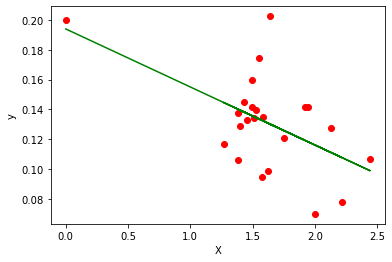

In [386]:
y_pred = regression_model.coef_ * x + regression_model.intercept_
  
plt.scatter(x, y, color = 'red')
plt.plot(x, y_pred, color = 'green')
plt.xlabel('X')
plt.ylabel('y')

In [128]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
fig = px.line(summary1, x=summary1.index, y='CHEM_share', title = 'Chemtrails')
fig.add_scatter(x=summary1.index, y=summary1['REICH_share'], name = 'Reichsbürger')
fig.add_scatter(x=summary1.index, y=summary1['Q_share'], name = 'Q_Anon')
fig.add_scatter(x=summary1.index, y=summary1['PIZZA_share'], name = 'Pizzagate')

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly conspiracy dicussions"
)

fig.show()

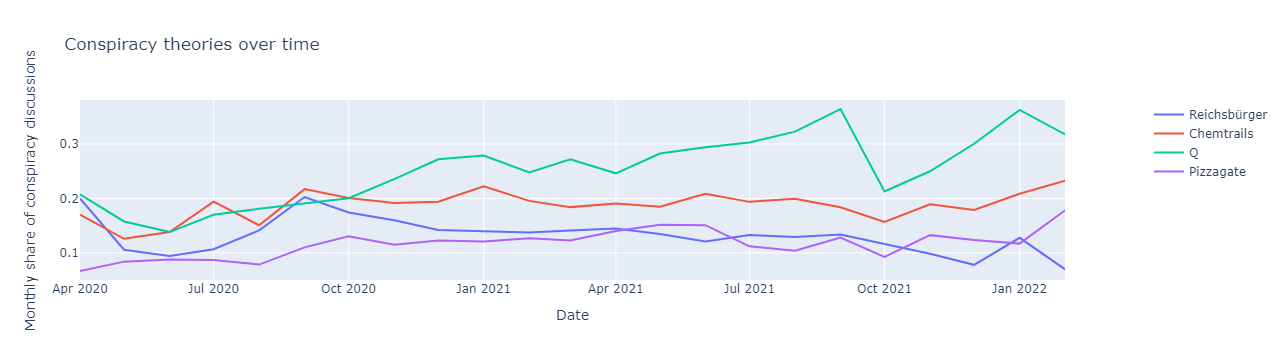

In [129]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
#fig.add_trace(go.Scatter(x=summary.index, y=summary['bundles_total'], name = 'all_bundles'), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions"
)

fig.show()
fig.write_image("images/conspiracy_distribution.svg")

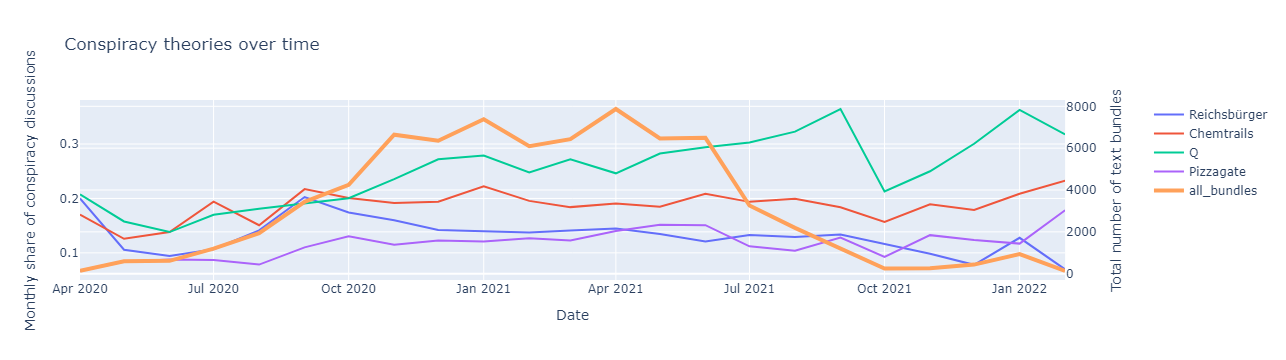

In [130]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['bundles_total'], name = 'all_bundles', line = dict(width = 4)), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions", yaxis2=dict(title="Total number of text bundles",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.show()
fig.write_image("images/conspiracy_distribution_with_total.svg")

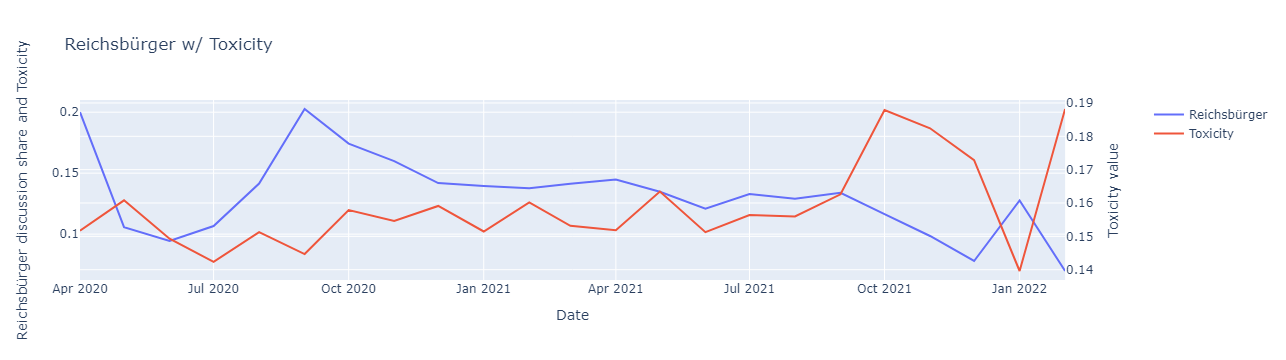

In [397]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_toxicity'], name = 'Toxicity'), secondary_y = True)
#fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
#fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
#fig.add_trace(go.Scatter(x=summary.index, y=summary['bundles_total'], name = 'all_bundles'), secondary_y = True)

fig.update_layout(
    title="Reichsbürger w/ Toxicity", xaxis_title="Date", yaxis_title="Reichsbürger discussion share and Toxicity", yaxis2=dict(title="Toxicity value",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/reich_toxic.svg")
fig.show()

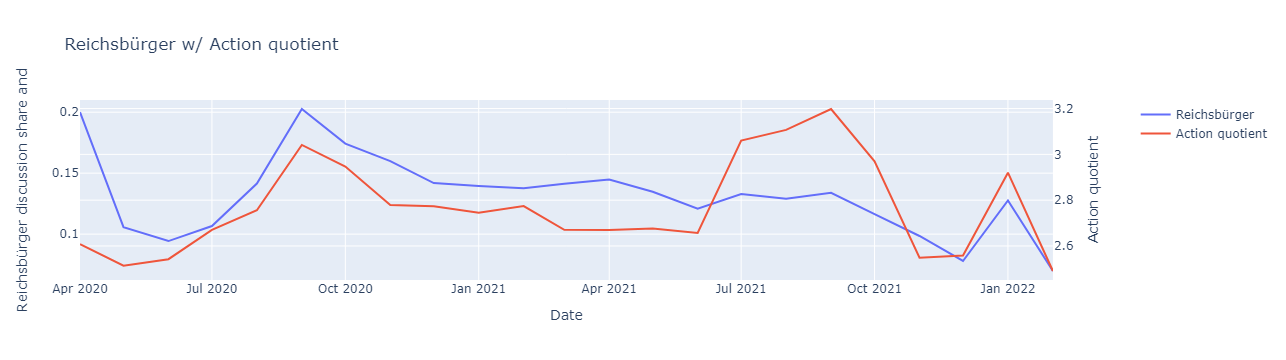

In [400]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_action'], name = 'Action quotient'), secondary_y = True)

fig.update_layout(
    title="Reichsbürger w/ Action quotient", xaxis_title="Date", yaxis_title="Reichsbürger discussion share and", yaxis2=dict(title="Action quotient",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)


fig.write_image("images/reich_action.svg")
fig.show()

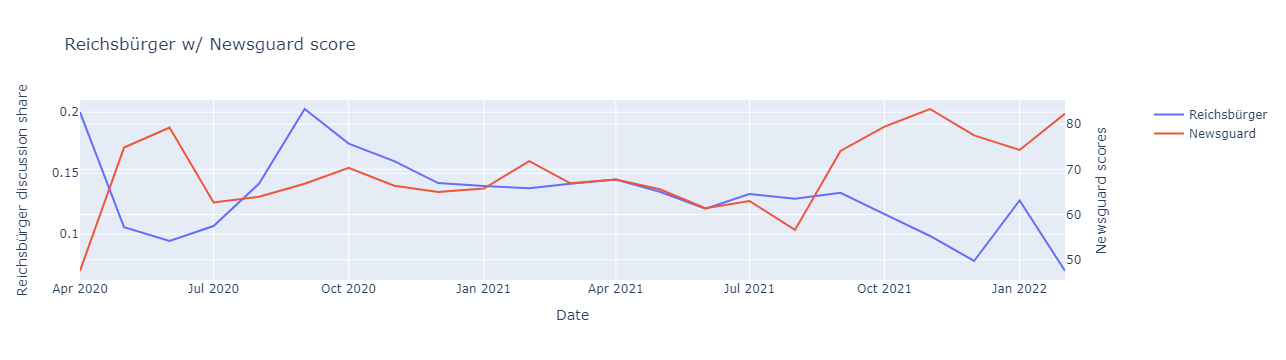

In [401]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_newsguard'], name = 'Newsguard'), secondary_y = True)

fig.update_layout(
    title="Reichsbürger w/ Newsguard score", xaxis_title="Date", yaxis_title="Reichsbürger discussion share", yaxis2=dict(title="Newsguard scores",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/reich_news.svg")
fig.show()

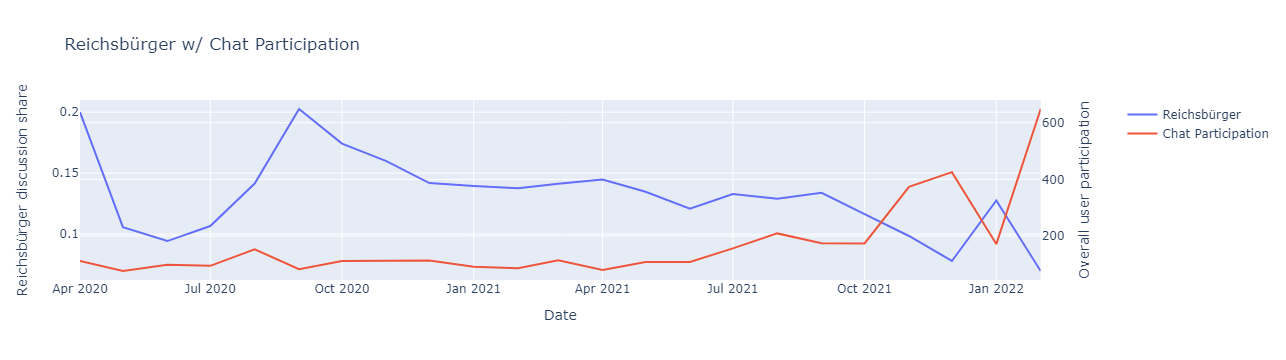

In [408]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_participation'], name = 'Chat Participation'), secondary_y = True)

fig.update_layout(
    title="Reichsbürger w/ Chat Participation", xaxis_title="Date", yaxis_title="Reichsbürger discussion share", yaxis2=dict(title="Overall user participation",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/reich_particip.svg")
fig.show()

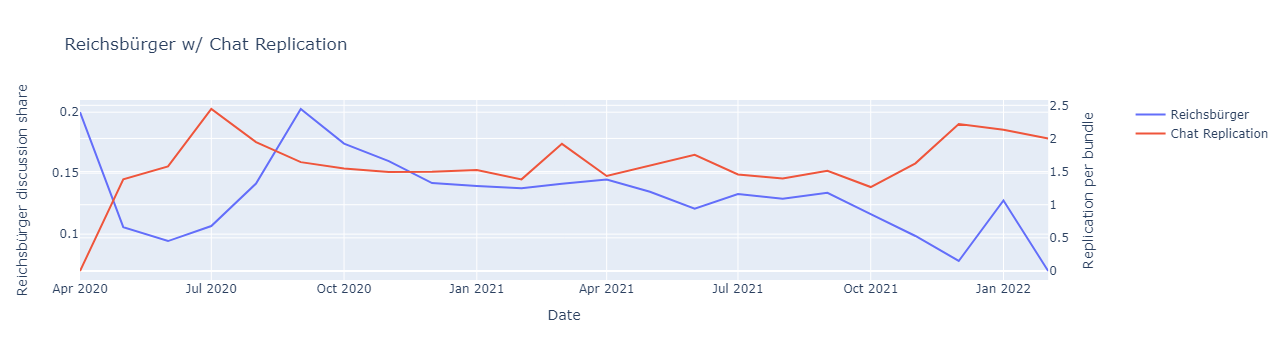

In [406]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_replication'], name = 'Chat Replication'), secondary_y = True)

fig.update_layout(
    title="Reichsbürger w/ Chat Replication", xaxis_title="Date", yaxis_title="Reichsbürger discussion share", yaxis2=dict(title="Replication per bundle",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/reich_repli.svg")
fig.show()

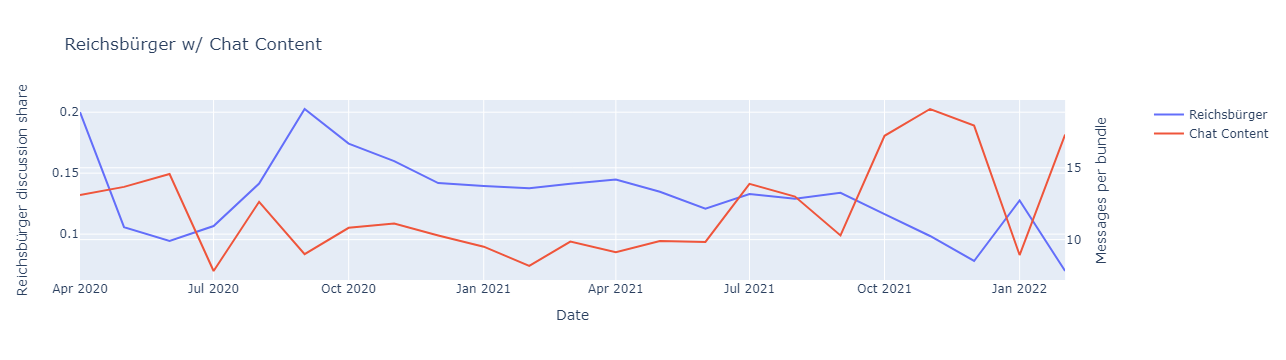

In [407]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_content'], name = 'Chat Content'), secondary_y = True)

fig.update_layout(
    title="Reichsbürger w/ Chat Content", xaxis_title="Date", yaxis_title="Reichsbürger discussion share", yaxis2=dict(title="Messages per bundle",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/reich_cont.svg")
fig.show()

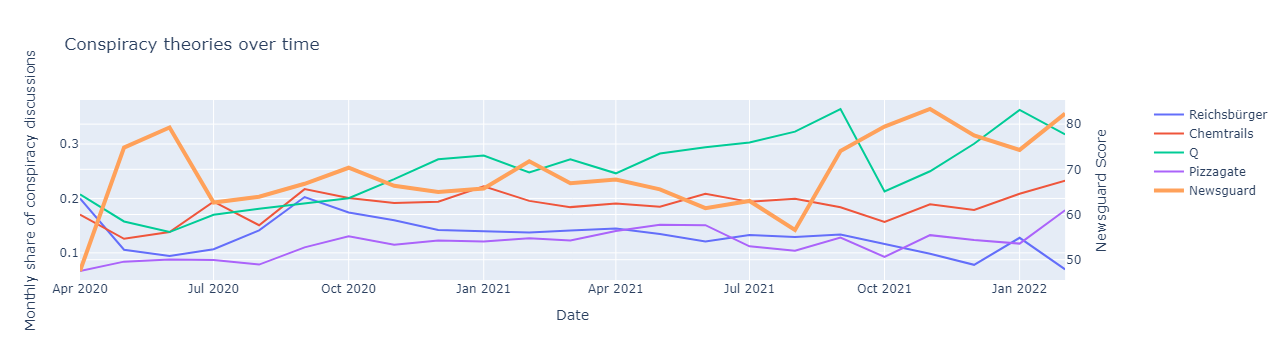

In [294]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_newsguard'], name = 'Newsguard', line = dict(width = 4)), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions", yaxis2=dict(title="Newsguard Score",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.show()
fig.write_image("images/conspiracy_distribution_with_newsguard.svg")

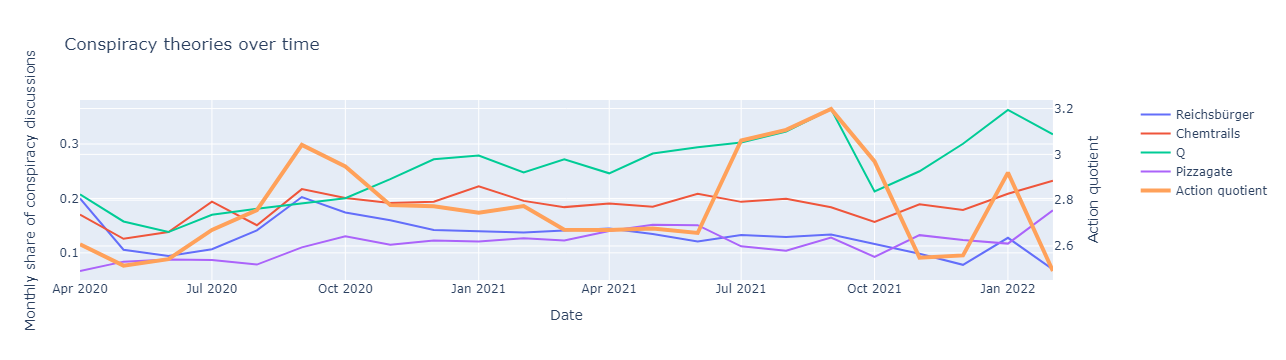

In [409]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_action'], name = 'Action quotient', line = dict(width = 4)), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions", yaxis2=dict(title="Action quotient",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/conspiracy_distribution_with_action.svg")
fig.show()

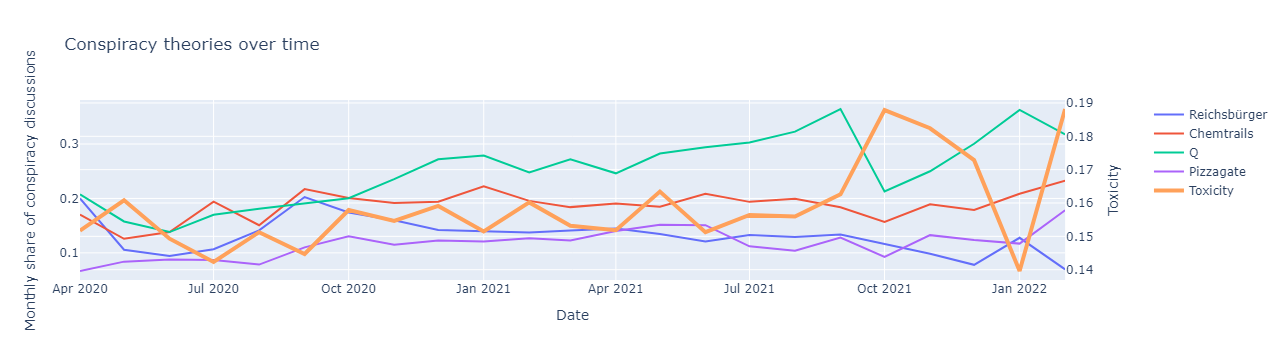

In [410]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_toxicity'], name = 'Toxicity', line = dict(width = 4)), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions", yaxis2=dict(title="Toxicity",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/conspiracy_distribution_with_toxicity.svg")
fig.show()

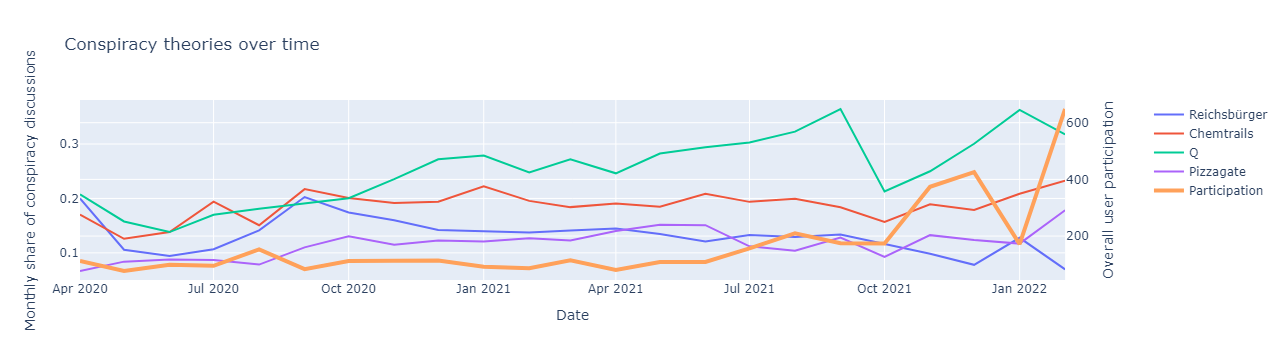

In [411]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_participation'], name = 'Participation', line = dict(width = 4)), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions", yaxis2=dict(title="Overall user participation",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)
fig.write_image("images/conspiracy_distribution_with_participation.svg")
fig.show()

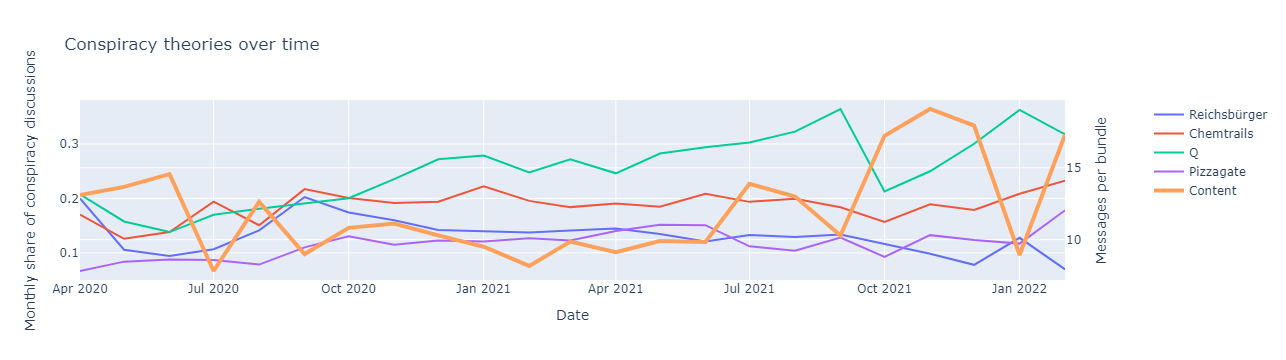

In [412]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_content'], name = 'Content', line = dict(width = 4)), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions", yaxis2=dict(title="Messages per bundle",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/conspiracy_distribution_with_content.svg")
fig.show()

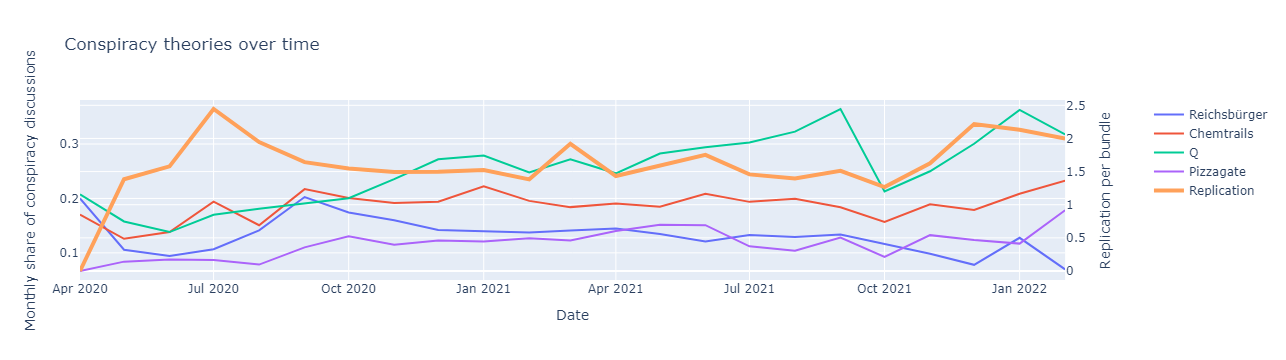

In [413]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['REICH_share'], name = 'Reichsbürger'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrails'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_replication'], name = 'Replication', line = dict(width = 4)), secondary_y = True)

fig.update_layout(
    title="Conspiracy theories over time", xaxis_title="Date", yaxis_title="Monthly share of conspiracy discussions", yaxis2=dict(title="Replication per bundle",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/conspiracy_distribution_with_replication.svg")
fig.show()

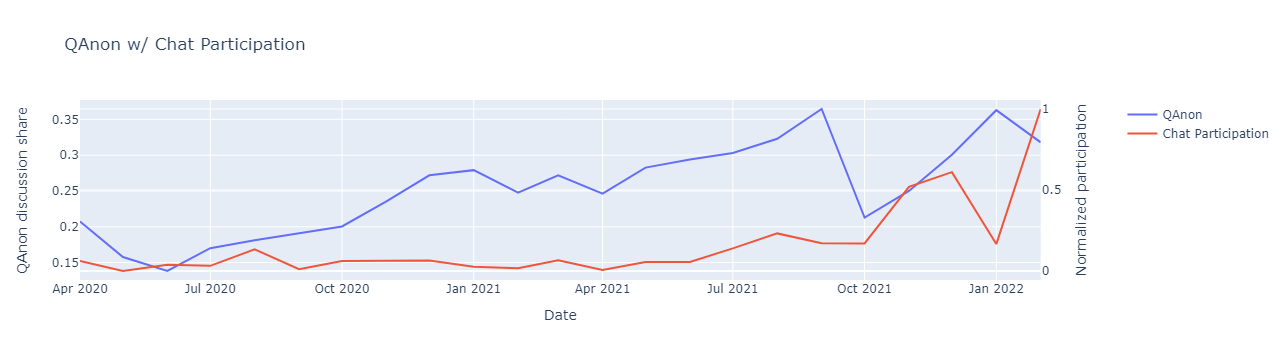

In [143]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'QAnon'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=norm['OVERALL_participation'], name = 'Chat Participation'), secondary_y = True)

fig.update_layout(
    title="QAnon w/ Chat Participation", xaxis_title="Date", yaxis_title="QAnon discussion share", yaxis2=dict(title="Normalized participation",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.show()
fig.write_image("images/q_particip.svg")

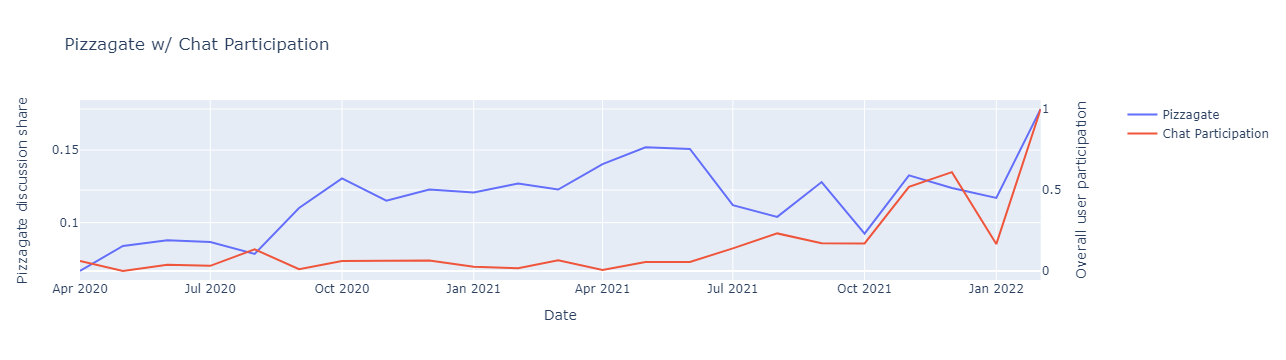

In [414]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=norm['OVERALL_participation'], name = 'Chat Participation'), secondary_y = True)

fig.update_layout(
    title="Pizzagate w/ Chat Participation", xaxis_title="Date", yaxis_title="Pizzagate discussion share", yaxis2=dict(title="Overall user participation",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.write_image("images/pizza_particip.svg")
fig.show()

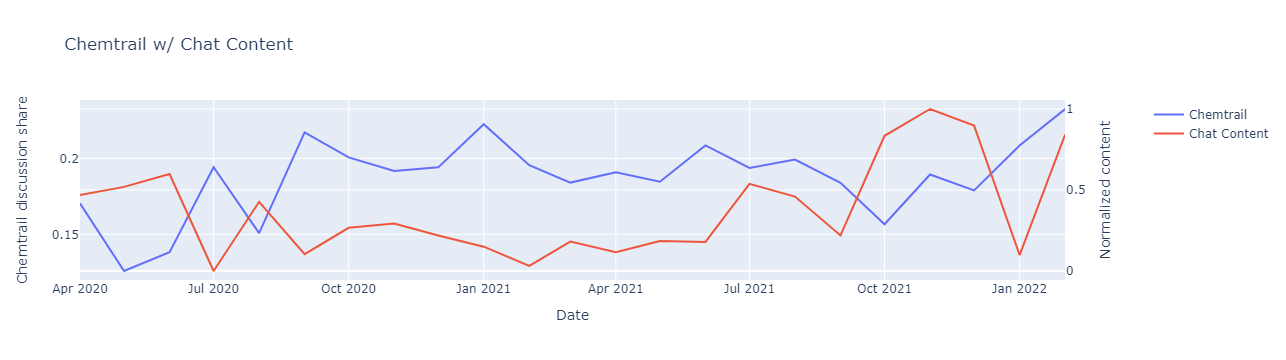

In [145]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['CHEM_share'], name = 'Chemtrail'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=norm['OVERALL_content'], name = 'Chat Content'), secondary_y = True)

fig.update_layout(
    title="Chemtrail w/ Chat Content", xaxis_title="Date", yaxis_title="Chemtrail discussion share", yaxis2=dict(title="Normalized content",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.show()
fig.write_image("images/chem_cont.svg")

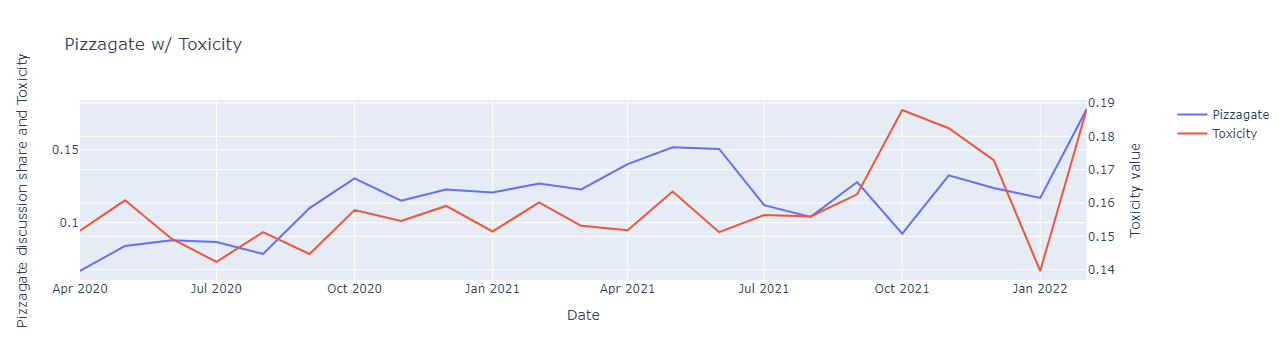

In [147]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
fig.add_trace(go.Scatter(x=summary.index, y=summary['OVERALL_toxicity'], name = 'Toxicity'), secondary_y = True)
#fig.add_trace(go.Scatter(x=summary.index, y=summary['Q_share'], name = 'Q'), secondary_y = False)
#fig.add_trace(go.Scatter(x=summary.index, y=summary['PIZZA_share'], name = 'Pizzagate'), secondary_y = False)
#fig.add_trace(go.Scatter(x=summary.index, y=summary['bundles_total'], name = 'all_bundles'), secondary_y = True)

fig.update_layout(
    title="Pizzagate w/ Toxicity", xaxis_title="Date", yaxis_title="Pizzagate discussion share and Toxicity", yaxis2=dict(title="Toxicity value",
                                                                                                                                  overlaying="y",
                                                                                                                                  side="right",
                                                                                                                                  position=0.15)
)

fig.show()
fig.write_image("images/pizza_toxic.svg")

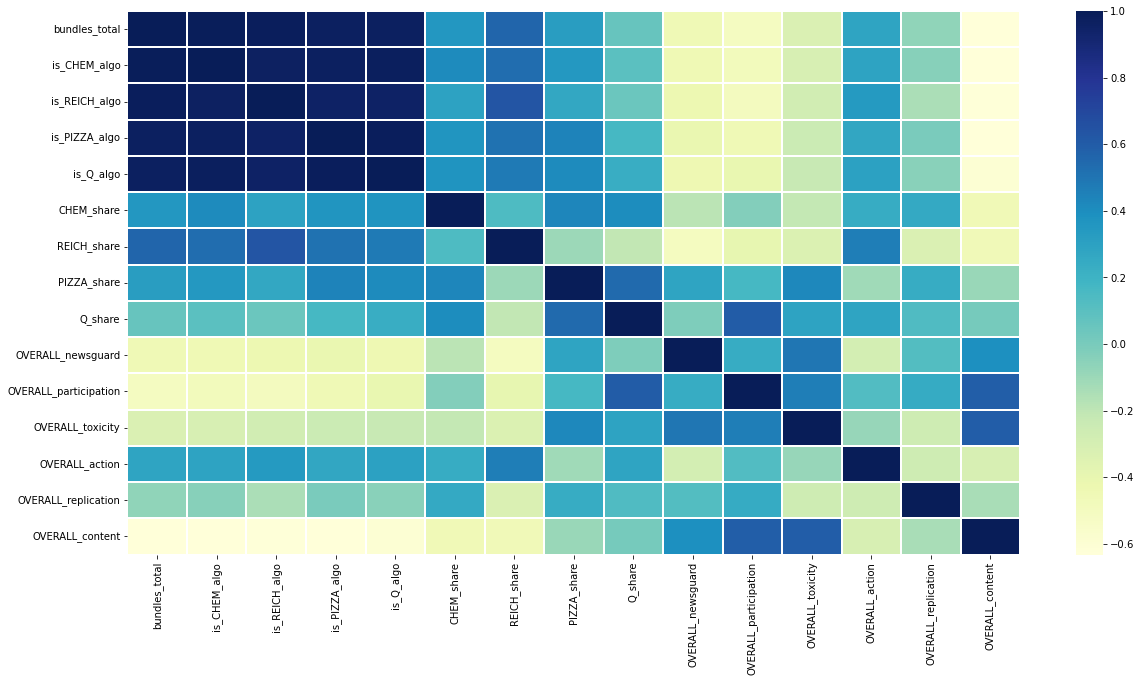

In [184]:
plt.figure(figsize = (20,10))
dataplot = sb.heatmap(norm.corr(method = 'spearman'), cmap="YlGnBu", annot=False, linewidth = 2)
plt.savefig("images/correlation_heatmap_spearman.svg")

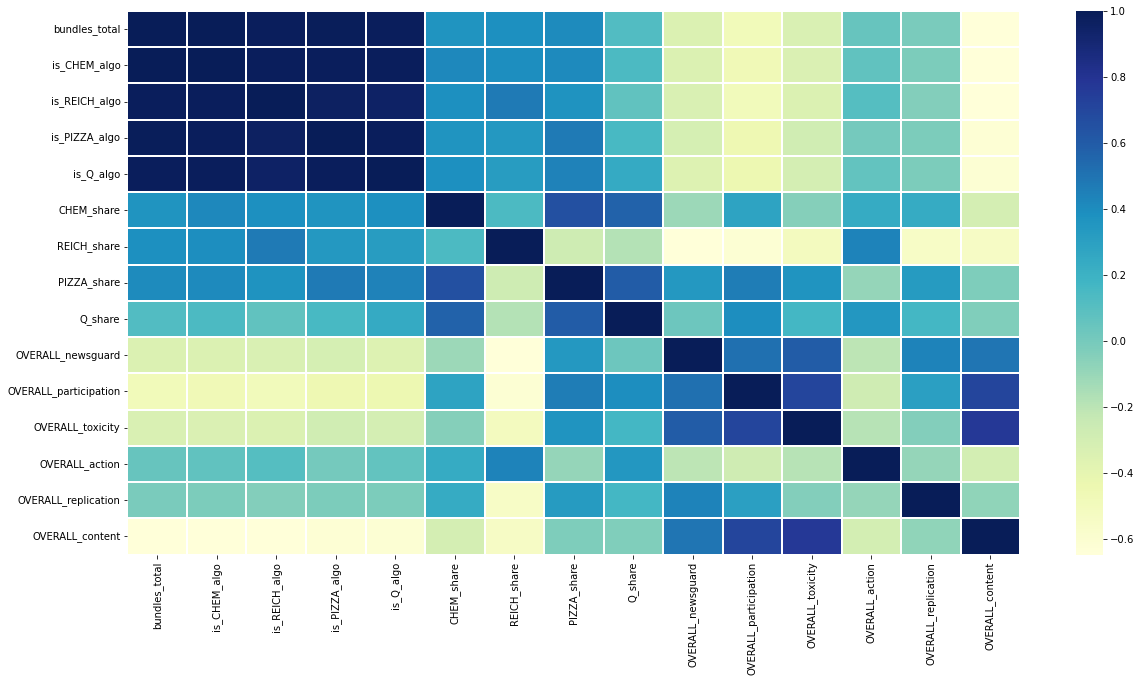

In [183]:
plt.figure(figsize = (20,10))
dataplot = sb.heatmap(summary.corr(), cmap="YlGnBu", annot=False, linewidth = 2, )

plt.savefig("images/correlation_heatmap_pearson.svg")

In [298]:
df1 = summary[['CHEM_share', 'REICH_share', 'Q_share', 'PIZZA_share']]

In [299]:
df2 = summary[['OVERALL_newsguard', 'OVERALL_participation', 'OVERALL_toxicity','OVERALL_action', 'OVERALL_replication', 'OVERALL_content']]

In [641]:
summary.columns

Index(['bundles_total', 'is_CHEM_algo', 'is_REICH_algo', 'is_PIZZA_algo',
       'is_Q_algo', 'CHEM_share', 'REICH_share', 'PIZZA_share', 'Q_share',
       'OVERALL_newsguard', 'OVERALL_participation', 'OVERALL_toxicity',
       'OVERALL_action', 'OVERALL_replication', 'OVERALL_content',
       'NEWS_NORM'],
      dtype='object')

In [300]:
from itertools import product
from scipy.stats import pearsonr, spearmanr


def compute_corr_and_p(df1, df2):
    corrs = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float64)
    pvals = corrs.copy()
  
    for i, j in product(df1.columns, df2.columns):
        corrs.loc[i,j], pvals.loc[i,j] = spearmanr(df1[i], df2[j])
  
    return corrs, pvals

def plot(corrs, pvals, siglevel=.05):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[(pvals >= siglevel) ] = True

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    plt.figure(figsize = (20,10))
    sns.heatmap(corrs, mask=mask, cmap=cmap, center=0, square=True, annot = True, linewidths=.5,
           cbar_kws={'shrink': .5})
    plt.savefig("images/relevant_correlation_p_value_spear.svg")

In [301]:
c, p = compute_corr_and_p(df1, df2)

/tmp/ipykernel_1193220/3591397033.py:15: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



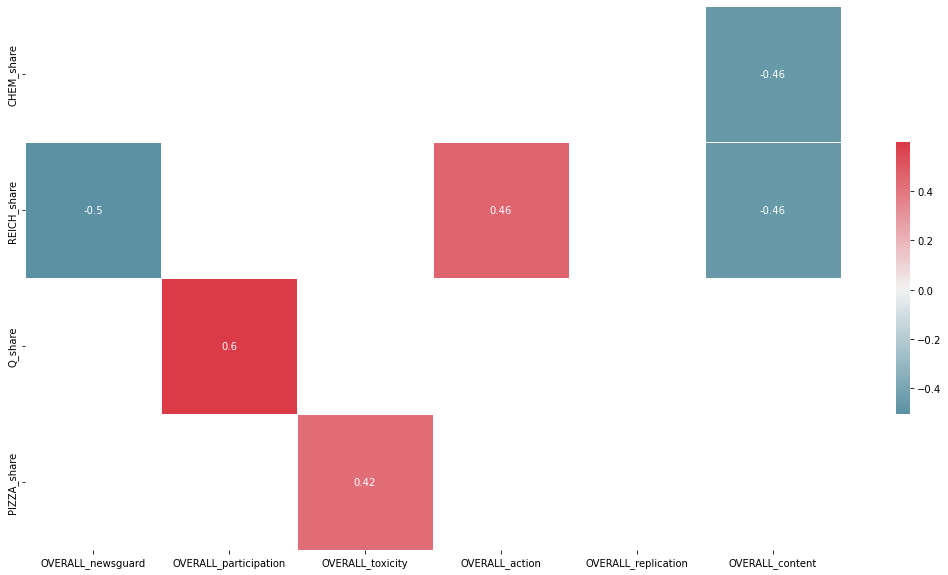

In [302]:
plot(c,p)

In [418]:
def compute_corr_and_p(df1, df2):
    corrs = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float64)
    pvals = corrs.copy()
  
    for i, j in product(df1.columns, df2.columns):
        corrs.loc[i,j], pvals.loc[i,j] = pearsonr(df1[i], df2[j])
  
    return corrs, pvals

def plot(corrs, pvals, siglevel=.05):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[(pvals >= siglevel) ] = True

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    plt.figure(figsize = (20,10))
    sns.heatmap(corrs, mask=mask, cmap=cmap, center=0, square=True, annot = True, linewidths=.5,
           cbar_kws={'shrink': .5})
    #plt.savefig("images/relevant_correlation_p_value_pearson.svg")

In [419]:
c, p = compute_corr_and_p(df1, df2)

/tmp/ipykernel_1193220/3093179432.py:11: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



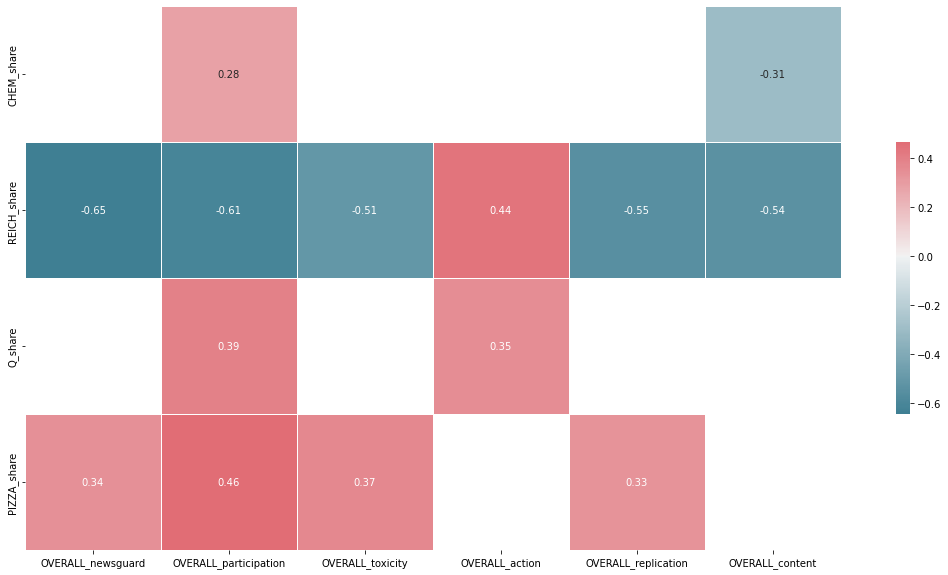

In [420]:
plot(c,p)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()
    
    
count_vectorizer = CountVectorizer(stop_words = stop_words)
count_data = count_vectorizer.fit_transform(prepro['messages_processed'][0])
plot_10_most_common_words(count_data, count_vectorizer)

In [279]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
             for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 5
number_words = 6
lda = LDA(n_components=number_topics)
lda.fit(count_data)
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
verursacht trauma indoktrination auslösen ddr stehst

Topic #1:
frau zeit mehr tag wirklich patrick

Topic #2:
einfach gut hast geht mehr gott

Topic #3:
mehr hast gut einfach geht gott

Topic #4:
verursacht trauma indoktrination auslösen ddr stehst


In [154]:
from bertopic import BERTopic

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

german_stop_words = stopwords.words('german')

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words= german_stop_words)
umap_model = UMAP(n_neighbors=10, n_components =2, metric="cosine", min_dist=0.0)
hdbscan_model = HDBSCAN(min_cluster_size=5, metric="euclidean", prediction_data=True)

In [155]:
topic_model = BERTopic(language="german",
                       vectorizer_model=vectorizer_model,
                       hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       calculate_probabilities=False,
                       verbose=True)

In [ ]:
doc_list = prepro["messages_processed"].tolist()
date_list = text_df["date"].apply(lambda x: x.strftime("%d-%m-%Y %H:%M:%S")).tolist()

In [ ]:
topics = topic_model.fit_transform(doc_list)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(doc_list)
vis_topics = topic_model.visualize_hierarchical_documents(doc_list, hierarchical_topics)

In [ ]:
topics_over_time = topic_model.topics_over_time(doc_list, date_list, nr_bins=20)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [ ]:
vis_topics

In [ ]:
topic_model.get_topic_info().head(10)